# Setup

In [45]:
import sys, subprocess

print("Using Python:", sys.executable)

subprocess.check_call([sys.executable, "-m", "pip", "install", "xlrd>=2.0.1"])

Using Python: C:\Users\uzair\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe


0

In [46]:
import xlrd
print("xlrd version:", xlrd.__version__)

xlrd version: 2.0.2


In [1]:
#!pip install geopandas rasterio rasterstats shapely pycountry
#!pip install openpyxl xlrd>=2.0.1

import io
import zipfile
import requests
from pathlib import Path

import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from rasterstats import zonal_stats
import pycountry

from ipywidgets import interact, interactive_output, Textarea, IntSlider, VBox, HBox, HTML
from ipywidgets import Textarea, Dropdown, IntSlider, VBox, HBox, HTML, interactive_output

DATA_DIR = Path("data")

GPW_DIR = DATA_DIR / "CIESIN_SEDAC_GPWv4_APCT_WPP_2015_R11_4.11-20251108_211123"
GDIS_DIR = DATA_DIR / "pend-gdis-1960-2018-disasterlocations"
WORLD_GEOJSON = DATA_DIR / "world.geojson"

GPW_TIF_DIR = DATA_DIR / "gpw_tifs"
GPW_TIF_DIR.mkdir(exist_ok=True)

GDIS_DIR = DATA_DIR / "pend-gdis-1960-2018-disasterlocations"
JPN_GEOJSON = DATA_DIR / "prefectures.geojson"

Run above cell, all cells in Merging Disasters and Population, then only focus on risk profile experimentation

In [6]:
# --- load world boundaries and create iso3 / country columns ---

world = gpd.read_file(WORLD_GEOJSON)

# try to find a 3-letter country code column
iso_candidates = ["iso_a3", "ISO_A3", "adm0_a3", "ADM0_A3", "iso3", "ISO3", "id"]
name_candidates = ["ADMIN", "admin", "NAME", "name", "NAME_LONG"]

iso_col = next((c for c in iso_candidates if c in world.columns), None)
name_col = next((c for c in name_candidates if c in world.columns), None)

if iso_col is None:
    # fall back: derive from name via pycountry (best-effort)
    def name_to_iso3(name):
        try:
            return pycountry.countries.search_fuzzy(name)[0].alpha_3
        except LookupError:
            return None

    world["iso3"] = world[name_col].apply(name_to_iso3)
else:
    world["iso3"] = world[iso_col].astype(str).str.upper().replace({"-99": np.nan})

if name_col is not None:
    world["country"] = world[name_col]
else:
    world["country"] = world["iso3"]  # worst-case fallback

# keep only valid iso3
world = world[world["iso3"].notna()].reset_index(drop=True)

world[["iso3", "country"]].head()

,iso3,country
0,AFG,Afghanistan
1,AGO,Angola
2,ALB,Albania
3,ARE,United Arab Emirates
4,ARG,Argentina


# Dataset: Global Population

## Data Preprocessing

In [5]:
# --- unzip selected GPWv4 rasters (30-min) ---

pop_years = [2000, 2005, 2010, 2015, 2020]

for year in pop_years:
    zip_path = GPW_DIR / f"gpw-v4-population-count-adjusted-to-2015-unwpp-country-totals-rev11_{year}_30_min_tif.zip"
    out_tif = GPW_TIF_DIR / f"gpw_pop_{year}_30min.tif"
    if out_tif.exists():
        continue

    print(f"Extracting {zip_path.name} -> {out_tif.name}")
    with zipfile.ZipFile(zip_path, "r") as z:
        # there should be exactly one tif inside
        tif_name = [f for f in z.namelist() if f.lower().endswith(".tif")][0]
        with z.open(tif_name) as src, open(out_tif, "wb") as dst:
            dst.write(src.read())

list(GPW_TIF_DIR.glob("*.tif"))

Extracting gpw-v4-population-count-adjusted-to-2015-unwpp-country-totals-rev11_2000_30_min_tif.zip -> gpw_pop_2000_30min.tif
Extracting gpw-v4-population-count-adjusted-to-2015-unwpp-country-totals-rev11_2005_30_min_tif.zip -> gpw_pop_2005_30min.tif
Extracting gpw-v4-population-count-adjusted-to-2015-unwpp-country-totals-rev11_2010_30_min_tif.zip -> gpw_pop_2010_30min.tif
Extracting gpw-v4-population-count-adjusted-to-2015-unwpp-country-totals-rev11_2015_30_min_tif.zip -> gpw_pop_2015_30min.tif
Extracting gpw-v4-population-count-adjusted-to-2015-unwpp-country-totals-rev11_2020_30_min_tif.zip -> gpw_pop_2020_30min.tif


[WindowsPath('data/gpw_tifs/gpw_pop_2000_30min.tif'),
 WindowsPath('data/gpw_tifs/gpw_pop_2005_30min.tif'),
 WindowsPath('data/gpw_tifs/gpw_pop_2010_30min.tif'),
 WindowsPath('data/gpw_tifs/gpw_pop_2015_30min.tif'),
 WindowsPath('data/gpw_tifs/gpw_pop_2020_30min.tif')]

In [8]:
# --- compute country-level population totals for each year ---

pop_records = []

for year in pop_years:
    tif_path = GPW_TIF_DIR / f"gpw_pop_{year}_30min.tif"
    print(f"Computing zonal stats for {year}...")
    
    zs = zonal_stats(
        world,
        tif_path,
        stats=["sum"],
        nodata=-9999,
        geojson=False
    )
    
    # attach results to world in-memory and also build long table
    sums = [row.get("sum", np.nan) for row in zs]
    world[f"pop_{year}"] = sums

    for (iso3, country_name, total_pop) in zip(world["iso3"], world["country"], sums):
        if pd.isna(total_pop):
            continue
        pop_records.append({
            "iso3": iso3,
            "country": country_name,
            "year": year,
            "pop_total": float(total_pop)
        })

country_pop = pd.DataFrame(pop_records)
country_pop.head(), country_pop["year"].value_counts()

Computing zonal stats for 2000...


C:\Users\uzair\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\numpy\_core\_methods.py:53: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
C:\Users\uzair\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\numpy\_core\_methods.py:53: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
C:\Users\uzair\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\numpy\_core\_methods.py:53: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
C:\Users\uzair\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\numpy\_core\_methods.py:53:

Computing zonal stats for 2005...


C:\Users\uzair\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\numpy\_core\_methods.py:53: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
C:\Users\uzair\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\numpy\_core\_methods.py:53: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
C:\Users\uzair\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\numpy\_core\_methods.py:53: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
C:\Users\uzair\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\numpy\_core\_methods.py:53:

Computing zonal stats for 2010...


C:\Users\uzair\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\numpy\_core\_methods.py:53: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
C:\Users\uzair\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\numpy\_core\_methods.py:53: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
C:\Users\uzair\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\numpy\_core\_methods.py:53: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
C:\Users\uzair\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\numpy\_core\_methods.py:53:

Computing zonal stats for 2015...


C:\Users\uzair\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\numpy\_core\_methods.py:53: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
C:\Users\uzair\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\numpy\_core\_methods.py:53: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
C:\Users\uzair\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\numpy\_core\_methods.py:53: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
C:\Users\uzair\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\numpy\_core\_methods.py:53:

Computing zonal stats for 2020...


C:\Users\uzair\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\numpy\_core\_methods.py:53: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
C:\Users\uzair\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\numpy\_core\_methods.py:53: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
C:\Users\uzair\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\numpy\_core\_methods.py:53: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
C:\Users\uzair\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\numpy\_core\_methods.py:53:

(  iso3               country  year    pop_total
 0  AFG           Afghanistan  2000  20162142.00
 1  AGO                Angola  2000  15214663.00
 2  ALB               Albania  2000   2796361.00
 3  ARE  United Arab Emirates  2000   2780483.75
 4  ARG             Argentina  2000  37855272.00,
 year
 2000    176
 2005    176
 2010    176
 2015    176
 2020    176
 Name: count, dtype: int64)

## Comparison Plots

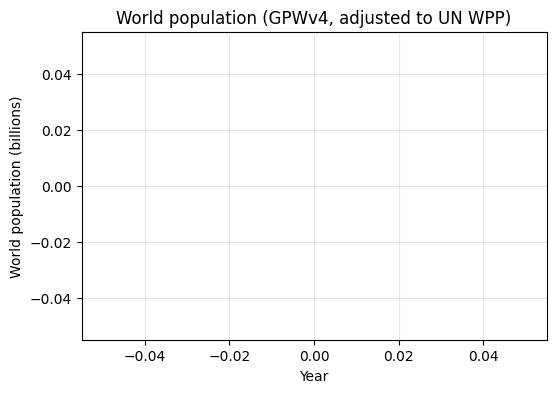

In [21]:
# aggregate to global totals
pop_global = (
    country_pop
    .groupby("year", as_index=False)["pop_total"]
    .sum()
)

plt.figure(figsize=(6,4))
plt.plot(pop_global["year"], pop_global["pop_total"] / 1e9, marker="o")
plt.xlabel("Year")
plt.ylabel("World population (billions)")
plt.title("World population (GPWv4, adjusted to UN WPP)")
plt.grid(alpha=0.3)
plt.show()

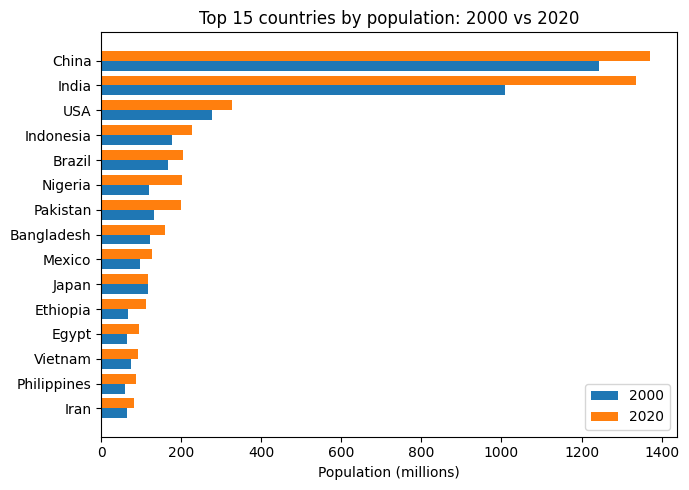

In [22]:
year_a, year_b = 2000, 2020

top_2020 = (
    country_pop.query("year == @year_b")
    .nlargest(15, "pop_total")
    .assign(pop_b=lambda d: d["pop_total"])
    [["iso3", "country", "pop_b"]]
)

top_2000 = (
    country_pop.query("year == @year_a")
    .loc[lambda d: d["iso3"].isin(top_2020["iso3"])]
    .assign(pop_a=lambda d: d["pop_total"])
    [["iso3", "pop_a"]]
)

top_compare = top_2020.merge(top_2000, on="iso3", how="left")

top_compare = top_compare.sort_values("pop_b", ascending=True)

fig, ax = plt.subplots(figsize=(7,5))

y = np.arange(len(top_compare))

ax.barh(y - 0.2, top_compare["pop_a"]/1e6, height=0.4, label=str(year_a))
ax.barh(y + 0.2, top_compare["pop_b"]/1e6, height=0.4, label=str(year_b))

ax.set_yticks(y)
ax.set_yticklabels(top_compare["country"])
ax.set_xlabel("Population (millions)")
ax.set_title(f"Top 15 countries by population: {year_a} vs {year_b}")
ax.legend()
plt.tight_layout()
plt.show()

C:\Users\uzair\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


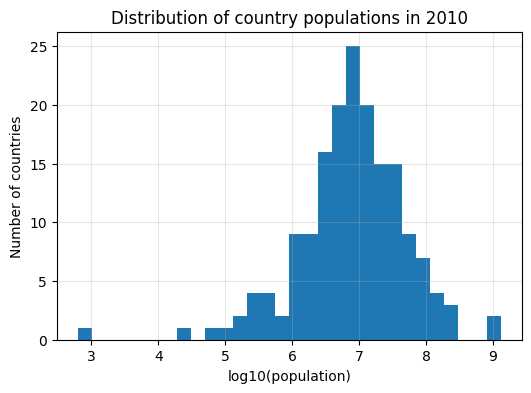

In [23]:
year0 = 2010
subset = country_pop.query("year == @year0")

plt.figure(figsize=(6,4))
plt.hist(np.log10(subset["pop_total"]), bins=30)
plt.xlabel("log10(population)")
plt.ylabel("Number of countries")
plt.title(f"Distribution of country populations in {year0}")
plt.grid(alpha=0.3)
plt.show()

## Exporting Data

In [9]:
# --- save tidy population table ---

out_path = DATA_DIR / "country_population_gpwv4_2000_2020.csv"
country_pop.to_csv(out_path, index=False)
print("Saved:", out_path)

Saved: data\country_population_gpwv4_2000_2020.csv


# Dataset: GDIS

## Data Preprocessing

In [10]:
# --- load GDIS CSV ---

gdis_raw = pd.read_csv(GDIS_DIR / "pend-gdis-1960-2018-disasterlocations.csv")
gdis_raw.head()

,id,country,iso3,gwno,year,geo_id,geolocation,level,adm1,adm2,adm3,location,historical,hist_country,disastertype,disasterno,latitude,longitude
0,109,Albania,ALB,339.0,2009,346,Ana E Malit,3,Shkoder,Shkodres,Ana E Malit,Ana E Malit,0,NaN,flood,2009-0631,42.020948,19.418317
1,109,Albania,ALB,339.0,2009,351,Bushat,3,Shkoder,Shkodres,Bushat,Bushat,0,NaN,flood,2009-0631,41.959294,19.514309
2,175,Angola,AGO,540.0,2001,760,Onjiva,3,Cunene,Cuanhama,Onjiva,Onjiva,0,NaN,flood,2001-0146,-17.093484,15.665758
3,187,Angola,AGO,540.0,2009,710,Evale,3,Cunene,Cuanhama,Evale,Evale,0,NaN,flood,2009-0092,-16.531533,15.773987
4,187,Angola,AGO,540.0,2009,749,Mupa,3,Cunene,Cuvelai,Mupa,Mupa,0,NaN,flood,2009-0092,-16.200065,15.844189


In [11]:
# --- normalize key columns in GDIS ---

def first_existing(cols, candidates):
    for c in candidates:
        if c in cols:
            return c
    return None

cols = gdis_raw.columns.tolist()

lon_col = first_existing(cols, ["longitude", "Longitude", "lon", "Long", "LONG"])
lat_col = first_existing(cols, ["latitude", "Latitude", "lat", "Lat", "LAT"])
year_col = first_existing(cols, ["year", "Year", "YEAR"])
dtype_col = first_existing(cols, ["disastertype", "disaster_type", "disasterType"])
country_col = first_existing(cols, ["country", "Country", "COUNTRY"])
iso3_col = first_existing(cols, ["iso3", "ISO3", "iso", "ISO"])

rename_map = {}
if lon_col: rename_map[lon_col] = "lon"
if lat_col: rename_map[lat_col] = "lat"
if year_col: rename_map[year_col] = "year"
if dtype_col: rename_map[dtype_col] = "disaster_type"
if country_col: rename_map[country_col] = "country"
if iso3_col: rename_map[iso3_col] = "iso3"

gdis = gdis_raw.rename(columns=rename_map)

# keep only rows with usable location & year
gdis = gdis.dropna(subset=["lon", "lat", "year"])
gdis["year"] = gdis["year"].astype(int)

# standardize disaster type text
gdis["disaster_type"] = gdis["disaster_type"].astype(str).str.strip()

gdis[["lon", "lat", "year", "disaster_type", "country", "iso3"]].head()

,lon,lat,year,disaster_type,country,iso3
0,19.418317,42.020948,2009,flood,Albania,ALB
1,19.514309,41.959294,2009,flood,Albania,ALB
2,15.665758,-17.093484,2001,flood,Angola,AGO
3,15.773987,-16.531533,2009,flood,Angola,AGO
4,15.844189,-16.200065,2009,flood,Angola,AGO


In [12]:
# --- convert GDIS to GeoDataFrame ---

gdis_gdf = gpd.GeoDataFrame(
    gdis,
    geometry=gpd.points_from_xy(gdis["lon"], gdis["lat"]),
    crs="EPSG:4326"
)

# reuse 'world' from earlier (has iso3 + country + geometry)
world_wgs84 = world.to_crs("EPSG:4326")

world_for_join = world_wgs84[["iso3", "country", "geometry"]].rename(
    columns={"iso3": "iso3_world", "country": "country_world"}
)

gdis_joined = gpd.sjoin(
    gdis_gdf,
    world_for_join,
    how="left",
    predicate="within"
)

# prefer GDIS iso3 if present, else from spatial join
if "iso3" in gdis_joined.columns:
    gdis_joined["iso3_final"] = gdis_joined["iso3"].fillna(gdis_joined["iso3_world"])
else:
    gdis_joined["iso3_final"] = gdis_joined["iso3_world"]

if "country" in gdis_joined.columns:
    gdis_joined["country_final"] = gdis_joined["country"].fillna(gdis_joined["country_world"])
else:
    gdis_joined["country_final"] = gdis_joined["country_world"]

gdis_joined = gdis_joined.drop(columns=["index_right"], errors="ignore")

gdis_joined[["year", "disaster_type", "iso3_final", "country_final"]].head()

,year,disaster_type,iso3_final,country_final
0,2009,flood,ALB,Albania
1,2009,flood,ALB,Albania
2,2001,flood,AGO,Angola
3,2009,flood,AGO,Angola
4,2009,flood,AGO,Angola


In [14]:
# --- construct a clean GDIS table with iso3 & country ---

gdis_clean = gdis_joined.copy()

# If original iso3/country exist, drop them so we don't get duplicates
for col in ["iso3", "country", "iso3_world", "country_world"]:
    if col in gdis_clean.columns:
        # keep the *_final versions instead
        if col in ["iso3", "country"]:
            print(f"Dropping original column '{col}' (we'll use *_final)")
        gdis_clean = gdis_clean.drop(columns=[col])

# Now create clean columns from *_final
gdis_clean["iso3"] = gdis_joined["iso3_final"]
gdis_clean["country"] = gdis_joined["country_final"]

# Finally drop the *_final helper columns
for col in ["iso3_final", "country_final"]:
    if col in gdis_clean.columns:
        gdis_clean = gdis_clean.drop(columns=[col])

# keep only rows with a country assignment
gdis_clean = gdis_clean[gdis_clean["iso3"].notna()].reset_index(drop=True)

gdis_clean[["year", "disaster_type", "iso3", "country"]].head()

Dropping original column 'iso3' (we'll use *_final)
Dropping original column 'country' (we'll use *_final)


,year,disaster_type,iso3,country
0,2009,flood,ALB,Albania
1,2009,flood,ALB,Albania
2,2001,flood,AGO,Angola
3,2009,flood,AGO,Angola
4,2009,flood,AGO,Angola


In [15]:
# --- optionally align GDIS to 2000-2018 window ---

gdis_clean = gdis_clean.query("year >= 2000 and year <= 2018").copy()
gdis_clean["year"].describe()

count    29708.000000
mean      2009.161101
std          5.290386
min       2000.000000
25%       2005.000000
50%       2009.000000
75%       2014.000000
max       2018.000000
Name: year, dtype: float64

In [16]:
def decade_bucket(y):
    if y < 2000:
        return np.nan
    if y < 2010:
        return "2000–2009"
    elif y < 2020:
        return "2010–2018"
    else:
        return "other"

gdis_clean["decade"] = gdis_clean["year"].apply(decade_bucket)
gdis_clean["decade"].value_counts(dropna=False)

decade
2000–2009    15329
2010–2018    14379
Name: count, dtype: int64

In [17]:
# --- per-country & decade disaster counts ---

gdis_country_decade = (
    gdis_clean
    .dropna(subset=["decade"])
    .groupby(["iso3", "country", "decade"])
    .agg(
        n_events=("disaster_type", "size"),
        n_types=("disaster_type", "nunique")
    )
    .reset_index()
)

gdis_country_decade.head()

,iso3,country,decade,n_events,n_types
0,240,Ukraine,2000–2009,1,1
1,AFG,Afghanistan,2000–2009,228,6
2,AFG,Afghanistan,2010–2018,177,6
3,AGO,Angola,2000–2009,72,1
4,AGO,Angola,2010–2018,23,1


In [18]:
gdis_country_year = (
    gdis_clean
    .groupby(["iso3", "country", "year"])
    .agg(
        n_events=("disaster_type", "size"),
        n_types=("disaster_type", "nunique")
    )
    .reset_index()
)

gdis_country_year.head()

,iso3,country,year,n_events,n_types
0,240,Ukraine,2002,1,1
1,AFG,Afghanistan,2000,16,2
2,AFG,Afghanistan,2001,13,2
3,AFG,Afghanistan,2002,14,3
4,AFG,Afghanistan,2003,16,2


## Comparison Plots

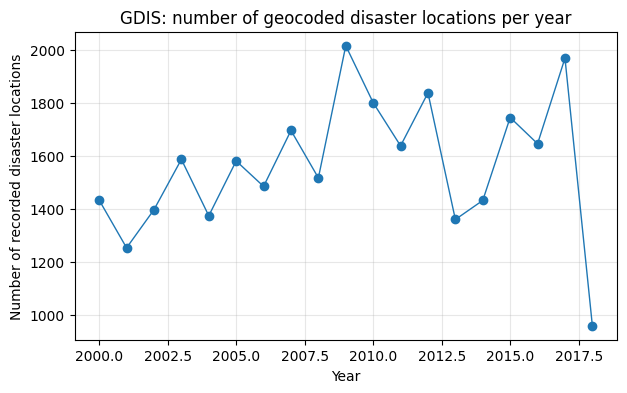

In [24]:
gdis_yearly = (
    gdis_clean
    .groupby("year", as_index=False)
    .agg(n_events=("disaster_type", "size"))
)

plt.figure(figsize=(7,4))
plt.plot(gdis_yearly["year"], gdis_yearly["n_events"], marker="o", linewidth=1)
plt.xlabel("Year")
plt.ylabel("Number of recorded disaster locations")
plt.title("GDIS: number of geocoded disaster locations per year")
plt.grid(alpha=0.3)
plt.show()


In [25]:
top_types = (
    gdis_clean["disaster_type"]
    .value_counts()
    .reset_index()
    .rename(columns={"index":"disaster_type", "disaster_type":"count"})
)

plt.figure(figsize=(7,4))
plt.barh(top_types["disaster_type"], top_types["count"])
plt.gca().invert_yaxis()
plt.xlabel("Number of locations")
plt.ylabel("Disaster type")
plt.title("GDIS: locations per disaster type (1960–2018)")
plt.tight_layout()
plt.show()

KeyError: 'disaster_type'

<Figure size 700x400 with 0 Axes>

In [26]:
gdis_2000 = gdis_clean.query("year >= 2000 and year <= 2018")

gdis_country_counts = (
    gdis_2000
    .groupby(["iso3", "country"], as_index=False)
    .agg(
        n_events=("disaster_type", "size"),
        n_types=("disaster_type", "nunique"),
        first_year=("year", "min"),
        last_year=("year", "max"),
    )
)

gdis_country_counts.sort_values("n_events", ascending=False).head(10)


,iso3,country,n_events,n_types,first_year,last_year
259,USA,United States,2482,7,2000,2018
185,PHL,Philippines,2174,3,2000,2015
101,IND,India,1685,7,2000,2018
43,CHN,China,1528,7,2000,2018
113,JPN,Japan,772,6,2000,2018
100,IDN,Indonesia,494,3,2000,2015
183,PER,Peru,484,7,2000,2018
184,PHI,Philippines,450,7,2000,2018
50,COL,Colombia,442,7,2000,2018
1,AFG,Afghanistan,405,6,2000,2018


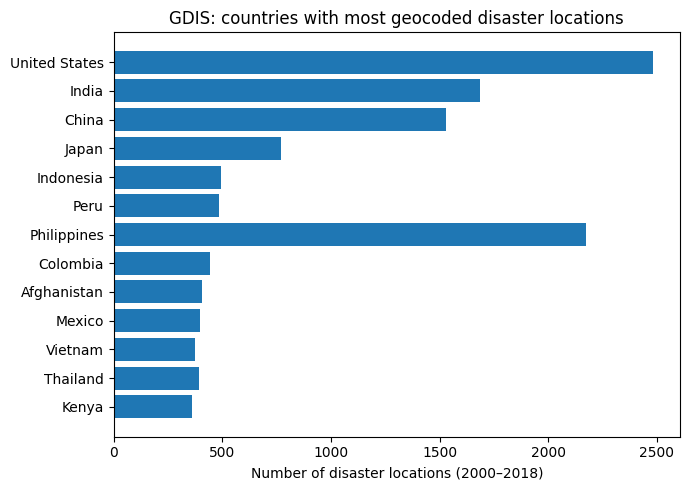

In [27]:
top_c = gdis_country_counts.nlargest(15, "n_events").sort_values("n_events")

plt.figure(figsize=(7,5))
plt.barh(top_c["country"], top_c["n_events"])
plt.xlabel("Number of disaster locations (2000–2018)")
plt.title("GDIS: countries with most geocoded disaster locations")
plt.tight_layout()
plt.show()

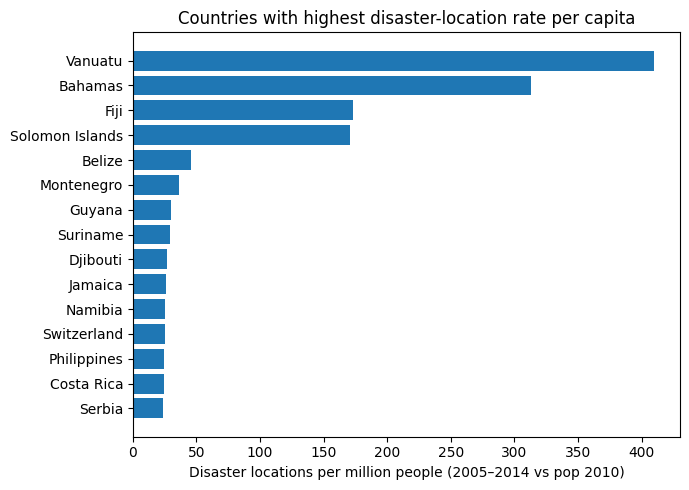

In [28]:
# define a decade-like bucket around 2010
gdis_2005_2014 = gdis_clean.query("year >= 2005 and year <= 2014")

gdis_decade = (
    gdis_2005_2014
    .groupby(["iso3", "country"], as_index=False)
    .agg(n_events=("disaster_type", "size"))
)

pop_2010 = country_pop.query("year == 2010")[["iso3", "pop_total"]]

risk = gdis_decade.merge(pop_2010, on="iso3", how="left")
risk = risk[risk["pop_total"].notna()].copy()
risk["events_per_million"] = risk["n_events"] / (risk["pop_total"] / 1e6)

risk_top = risk.nlargest(15, "events_per_million").sort_values("events_per_million")

plt.figure(figsize=(7,5))
plt.barh(risk_top["country"], risk_top["events_per_million"])
plt.xlabel("Disaster locations per million people (2005–2014 vs pop 2010)")
plt.title("Countries with highest disaster-location rate per capita")
plt.tight_layout()
plt.show()

## Map Plots

## Exporting Data

In [19]:
gdis_country_decade.to_csv(DATA_DIR / "gdis_country_decade_counts.csv", index=False)
gdis_country_year.to_csv(DATA_DIR / "gdis_country_year_counts.csv", index=False)
print("Saved GDIS aggregates.")

Saved GDIS aggregates.


# Dataset: GDIS-Japan

## Data Preprocessing

In [99]:
# Load prefecture key from Kaggle
prefecture_key = pd.read_csv(DATA_DIR / "prefecture_key_from_kaggle.csv")

# Canonical list (you already had this)
pref_names = [
    "Hokkaido", "Aomori", "Iwate", "Miyagi", "Akita", "Yamagata", "Fukushima",
    "Ibaraki", "Tochigi", "Gunma", "Saitama", "Chiba", "Tokyo", "Kanagawa",
    "Niigata", "Toyama", "Ishikawa", "Fukui", "Yamanashi", "Nagano", "Gifu",
    "Shizuoka", "Aichi",
    "Mie", "Shiga", "Kyoto", "Osaka", "Hyogo", "Nara", "Wakayama",
    "Tottori", "Shimane", "Okayama", "Hiroshima", "Yamaguchi",
    "Tokushima", "Kagawa", "Ehime", "Kochi",
    "Fukuoka", "Saga", "Nagasaki", "Kumamoto", "Oita", "Miyazaki", "Kagoshima", "Okinawa"
]
pref_names_lower = [p.lower() for p in pref_names]
pref_map_lower_to_canon = dict(zip(pref_names_lower, pref_names))

# Extra synonyms we might see in free text
pref_synonyms = {
    "gumma": "Gunma",      # weird historical spelling
    "tokyo-to": "Tokyo",
    "osaka-fu": "Osaka",
    "kyoto-fu": "Kyoto",
}

In [100]:
gdis_path = GDIS_DIR / "pend-gdis-1960-2018-disasterlocations.csv"
gdis = pd.read_csv(gdis_path)

gdis.head(), gdis.columns

(    id  country iso3   gwno  year  geo_id  geolocation  level     adm1  \
 0  109  Albania  ALB  339.0  2009     346  Ana E Malit      3  Shkoder   
 1  109  Albania  ALB  339.0  2009     351       Bushat      3  Shkoder   
 2  175   Angola  AGO  540.0  2001     760       Onjiva      3   Cunene   
 3  187   Angola  AGO  540.0  2009     710        Evale      3   Cunene   
 4  187   Angola  AGO  540.0  2009     749         Mupa      3   Cunene   
 
        adm2         adm3     location  historical hist_country disastertype  \
 0  Shkodres  Ana E Malit  Ana E Malit           0          NaN        flood   
 1  Shkodres       Bushat       Bushat           0          NaN        flood   
 2  Cuanhama       Onjiva       Onjiva           0          NaN        flood   
 3  Cuanhama        Evale        Evale           0          NaN        flood   
 4   Cuvelai         Mupa         Mupa           0          NaN        flood   
 
   disasterno   latitude  longitude  
 0  2009-0631  42.020948  19

In [101]:
# Restrict to Japan
gdis_jp = gdis[
    (gdis["iso3"] == "JPN")
    | (gdis["country"].str.contains("Japan", case=False, na=False))
].copy()

# Make sure we have the columns we expect
gdis_jp = gdis_jp.rename(columns={
    "disasterno": "disno",
    "disastertype": "disaster_type",
    "location": "location_str",
})

gdis_jp["year"] = pd.to_numeric(gdis_jp["year"], errors="coerce")
gdis_jp["disno"] = gdis_jp["disno"].astype(str)
gdis_jp["disaster_type"] = gdis_jp["disaster_type"].str.lower()
gdis_jp.head()

,id,country,iso3,gwno,year,geo_id,geolocation,level,adm1,adm2,adm3,location_str,historical,hist_country,disaster_type,disno,latitude,longitude
3727,3636,Japan,JPN,740.0,2003,11016,Ishinomaki,2,Miyagi,Ishinomaki,NaN,Ishinomaki,0,NaN,earthquake,2003-0354,38.483367,141.376057
3728,3636,Japan,JPN,740.0,2003,11469,Sendai,2,Miyagi,Sendai,NaN,Sendai,0,NaN,earthquake,2003-0354,38.300884,140.752094
3729,3665,Japan,JPN,740.0,2007,11358,Ojiya,2,Niigata,Ojiya,NaN,Ojiya,0,NaN,earthquake,2007-0258,37.287009,138.804951
3730,3665,Japan,JPN,740.0,2007,11648,Tsubame,2,Niigata,Tsubame,NaN,Tsubame,0,NaN,earthquake,2007-0258,37.660847,138.895094
3731,3668,Japan,JPN,740.0,2008,11141,Kurihara,2,Miyagi,Kurihara,NaN,Kurihara,0,NaN,earthquake,2008-0242,38.807624,140.944564


In [102]:
def infer_prefecture(adm1, location):
    """
    Try to guess the prefecture from adm1 or free-text location.
    Returns canonical English prefecture name (e.g. 'Tokyo') or None.
    """
    # helper: normalize a string and check against both canon + synonyms
    def match_str(s):
        s = s.strip().lower()
        # first try synonyms
        for syn, canon in pref_synonyms.items():
            if syn in s:
                return canon
        # then try canonical names
        for p_lower in pref_names_lower:
            if p_lower in s:
                return pref_map_lower_to_canon[p_lower]
        return None

    if isinstance(adm1, str):
        res = match_str(adm1)
        if res is not None:
            return res

    if isinstance(location, str):
        res = match_str(location)
        if res is not None:
            return res

    return None


gdis_jp["prefecture_canon"] = gdis_jp.apply(
    lambda row: infer_prefecture(row.get("adm1", None), row.get("location_str", None)),
    axis=1,
)

# Keep only rows where we assigned a prefecture
gdis_pref = gdis_jp[gdis_jp["prefecture_canon"].notna()].copy()

print("Assigned prefecture for", len(gdis_pref), "rows")
print("Top prefectures:")
print(gdis_pref["prefecture_canon"].value_counts().head())

# Attach region / island / capital from prefecture_key
# prefecture_key: 'prefecture' (Aichi-ken), 'prefecture_norm' (Aichi), 'region', 'capital', 'island'
meta = prefecture_key[["prefecture_norm", "region", "capital", "island"]].drop_duplicates()

gdis_pref = gdis_pref.merge(
    meta,
    left_on="prefecture_canon",
    right_on="prefecture_norm",
    how="left",
)

# A few sanity checks
print("\nGDIS-JP prefectures missing meta (region/island):")
print(
    gdis_pref[gdis_pref["region"].isna()][["prefecture_canon"]]
    .drop_duplicates()
)

Assigned prefecture for 1341 rows
Top prefectures:
prefecture_canon
Tokyo        51
Kagoshima    40
Niigata      38
Hyogo        37
Miyagi       34
Name: count, dtype: int64

GDIS-JP prefectures missing meta (region/island):
Empty DataFrame
Columns: [prefecture_canon]
Index: []


## Comparison Plots

## Map Plots

In [14]:
# 1. Load prefecture polygons
japan_pref = gpd.read_file("data/prefectures.geojson")

print(japan_pref.head())
print(japan_pref.crs)
print(japan_pref.columns)

     P                                           geometry
0  北海道  MULTIPOLYGON (((144.08144 44.12506, 144.08153 ...
1  青森県  MULTIPOLYGON (((140.73524 40.83351, 140.73476 ...
2  岩手県  MULTIPOLYGON (((142.01379 39.50042, 142.01379 ...
3  宮城県  MULTIPOLYGON (((140.56324 38.3772, 140.56281 3...
4  秋田県  MULTIPOLYGON (((140.0537 39.73879, 140.05364 3...
EPSG:4326
Index(['P', 'geometry'], dtype='object')


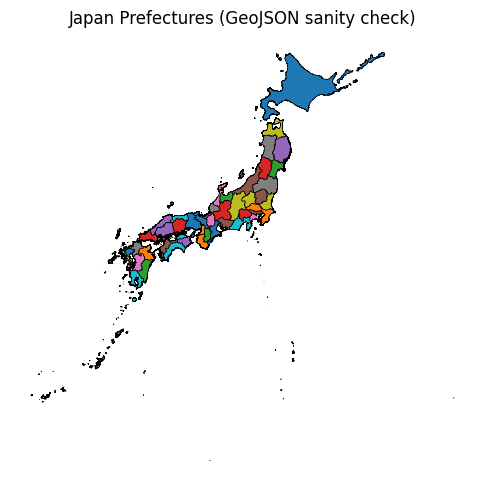

In [17]:
# 2. Quick static map
fig, ax = plt.subplots(figsize=(6, 8))
japan_pref.plot(ax=ax, edgecolor="black", linewidth=0.5, facecolor="#f0f0f0")
japan_pref.plot(
    column="P",
    categorical=True,
    legend=False,
    ax=ax,
    edgecolor="black",
    linewidth=0.4
)
ax.set_title("Japan Prefectures (GeoJSON sanity check)")
ax.set_axis_off()
plt.show()

## Exporting Data

In [104]:
# Final cleaned GDIS-Japan per-location table
gdis_pref_clean = gdis_pref[[
    "disno",
    "year",
    "disaster_type",
    "country",
    "iso3",
    "prefecture_canon",   # matches prefecture_norm
    "prefecture_norm",
    "region",
    "island",
    "capital",
    "location_str",
    "adm1",
    "adm2",
    "latitude",
    "longitude",
]].rename(columns={
    "prefecture_canon": "prefecture",
})

gdis_pref_clean.to_csv(DATA_DIR / "gdis_japan_prefecture_events.csv", index=False)
gdis_pref_clean

,disno,year,disaster_type,country,iso3,prefecture,prefecture_norm,region,island,capital,location_str,adm1,adm2,latitude,longitude
0,2003-0354,2003,earthquake,Japan,JPN,Miyagi,Miyagi,Tohoku,Honshu,Sendai-shi,Ishinomaki,Miyagi,Ishinomaki,38.483367,141.376057
1,2003-0354,2003,earthquake,Japan,JPN,Miyagi,Miyagi,Tohoku,Honshu,Sendai-shi,Sendai,Miyagi,Sendai,38.300884,140.752094
2,2007-0258,2007,earthquake,Japan,JPN,Niigata,Niigata,Chubu,Honshu,Niigata-shi,Ojiya,Niigata,Ojiya,37.287009,138.804951
3,2007-0258,2007,earthquake,Japan,JPN,Niigata,Niigata,Chubu,Honshu,Niigata-shi,Tsubame,Niigata,Tsubame,37.660847,138.895094
4,2008-0242,2008,earthquake,Japan,JPN,Miyagi,Miyagi,Tohoku,Honshu,Sendai-shi,Kurihara,Miyagi,Kurihara,38.807624,140.944564
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1336,2015-0456,2015,storm,Japan,JPN,Ibaraki,Ibaraki,Kanto,Honshu,Mito-shi,Ibaraki,Ibaraki,NaN,36.303588,140.319591
1337,2015-0456,2015,storm,Japan,JPN,Miyagi,Miyagi,Tohoku,Honshu,Sendai-shi,Miyagi provinces,Miyagi,NaN,38.446859,140.927086
1338,2015-0418,2015,flood,Japan,JPN,Tochigi,Tochigi,Kanto,Honshu,Utsunomiya-shi,Totigi provinces,Tochigi,NaN,36.689912,139.819213
1339,2015-0418,2015,flood,Japan,JPN,Miyagi,Miyagi,Tohoku,Honshu,Sendai-shi,Miyagi,Miyagi,NaN,38.446859,140.927086


# Dataset: Japan-only EM-DAT

## Data Preprocessing

In [105]:
emdat_path = DATA_DIR / "public_emdat_custom_request_2025-11-09_9249b98d-fb2c-426c-a383-435c3a136ad3.xlsx"
em = pd.read_excel(emdat_path)

em.columns, em.head()

(Index(['DisNo.', 'Historic', 'Classification Key', 'Disaster Group',
        'Disaster Subgroup', 'Disaster Type', 'Disaster Subtype',
        'External IDs', 'Event Name', 'ISO', 'Country', 'Subregion', 'Region',
        'Location', 'Origin', 'Associated Types', 'OFDA/BHA Response', 'Appeal',
        'Declaration', 'AID Contribution ('000 US$)', 'Magnitude',
        'Magnitude Scale', 'Latitude', 'Longitude', 'River Basin', 'Start Year',
        'Start Month', 'Start Day', 'End Year', 'End Month', 'End Day',
        'Total Deaths', 'No. Injured', 'No. Affected', 'No. Homeless',
        'Total Affected', 'Reconstruction Costs ('000 US$)',
        'Reconstruction Costs, Adjusted ('000 US$)',
        'Insured Damage ('000 US$)', 'Insured Damage, Adjusted ('000 US$)',
        'Total Damage ('000 US$)', 'Total Damage, Adjusted ('000 US$)', 'CPI',
        'Admin Units', 'Entry Date', 'Last Update'],
       dtype='object'),
           DisNo. Historic Classification Key Disaster Group Disast

In [106]:
# Filter to Japan, natural disasters
em_jp = em[(em["Country"] == "Japan") & (em["Disaster Group"] == "Natural")].copy()

# Standardize key columns
em_jp = em_jp.rename(columns={
    "DisNo.": "disno_raw",
    "Disaster Type": "disaster_type",
    "Disaster Subtype": "disaster_subtype",
    "Start Year": "start_year",
    "Start Month": "start_month",
    "Start Day": "start_day",
    "End Year": "end_year",
    "Total Deaths": "deaths",
    "No. Injured": "injured",
    "No. Affected": "affected",
    "No. Homeless": "homeless",
    "Total Affected": "total_affected",
    "Total Damage ('000 US$)": "damage_kusd",
    "Total Damage, Adjusted ('000 US$)": "damage_adj_kusd",
    "Location": "location_str_emdat",
})

# Build a join key compatible with GDIS:
#   2003-0354-JPN -> 2003-0354
em_jp["disno_raw"] = em_jp["disno_raw"].astype(str)
em_jp["disno_core"] = (
    em_jp["disno_raw"]
    .str.replace("-JPN", "", regex=False)
    .str.strip()
)

# Numeric cleanup for human impact
for col in ["deaths", "injured", "affected", "homeless", "total_affected"]:
    em_jp[col] = pd.to_numeric(em_jp[col], errors="coerce")

# A simple "raw" human impact; you can reweight later
em_jp["human_impact_raw"] = (
    em_jp[["deaths", "injured", "affected", "homeless"]]
    .fillna(0)
    .sum(axis=1)
)

# Economic impact
for col in ["damage_kusd", "damage_adj_kusd"]:
    em_jp[col] = pd.to_numeric(em_jp[col], errors="coerce")

# Prefer adjusted, otherwise plain
em_jp["damage_adj_usd"] = em_jp["damage_adj_kusd"].fillna(em_jp["damage_kusd"]) * 1_000

# Log10 scale for later weighting (clip at 1 to avoid -inf)
em_jp["damage_log10"] = np.log10(em_jp["damage_adj_usd"].clip(lower=1))

# Keep a trimmed EM-DAT table for joining / inspection
em_jp_trim = em_jp[[
    "disno_core",
    "disno_raw",
    "disaster_type",
    "disaster_subtype",
    "start_year",
    "end_year",
    "deaths",
    "injured",
    "affected",
    "homeless",
    "total_affected",
    "damage_kusd",
    "damage_adj_kusd",
    "damage_adj_usd",
    "damage_log10",
    "human_impact_raw",
    "location_str_emdat",
]]

em_jp_trim.head()

,disno_core,disno_raw,disaster_type,disaster_subtype,start_year,end_year,deaths,injured,affected,homeless,total_affected,damage_kusd,damage_adj_kusd,damage_adj_usd,damage_log10,human_impact_raw,location_str_emdat
0,1900-0008,1900-0008-JPN,Volcanic activity,Ash fall,1900,1900,30.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30.0,NaN
1,1901-0004,1901-0004-JPN,Earthquake,Tsunami,1901,1901,18.0,NaN,NaN,24.0,24.0,NaN,NaN,NaN,NaN,42.0,Sanriku
2,1902-0008,1902-0008-JPN,Volcanic activity,Ash fall,1902,1902,125.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,125.0,Torishima
3,1905-0007,1905-0007-JPN,Earthquake,Tsunami,1905,1905,41.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,41.0,Fukushima
4,1905-0009,1905-0009-JPN,Earthquake,Ground movement,1905,1905,11.0,NaN,177.0,NaN,177.0,NaN,NaN,NaN,NaN,188.0,Aki


In [108]:
# Prepare GDIS key
gdis_pref_clean = pd.read_csv(DATA_DIR / "gdis_japan_prefecture_events.csv")
gdis_pref_clean["disno_core"] = gdis_pref_clean["disno"].astype(str).str.strip()

# Merge
gdis_emdat = gdis_pref_clean.merge(
    em_jp_trim,
    on="disno_core",
    how="left",
    suffixes=("_gdis", "_emdat"),
)

# How many GDIS locations got EM-DAT info?
total_rows = len(gdis_emdat)
matched_rows = gdis_emdat["disno_raw"].notna().sum()
print(f"Total GDIS Japan location-rows: {total_rows}")
print(f"Rows matched to EM-DAT events:  {matched_rows} ({matched_rows/total_rows:.1%})")

Total GDIS Japan location-rows: 1341
Rows matched to EM-DAT events:  1306 (97.4%)


In [112]:
# Overall missingness for impact-related columns
impact_cols = [
    "deaths", "injured", "affected", "homeless", "total_affected",
    "damage_kusd", "damage_adj_kusd", "damage_adj_usd", "damage_log10",
    "human_impact_raw",
]

missing_summary = (
    em_jp_trim[impact_cols]
    .isna()
    .mean()
    .rename("frac_missing")
    .to_frame()
)
missing_summary["frac_nonmissing"] = 1 - missing_summary["frac_missing"]

missing_summary

,frac_missing,frac_nonmissing
deaths,0.149626,0.850374
injured,0.468828,0.531172
affected,0.501247,0.498753
homeless,0.882793,0.117207
total_affected,0.276808,0.723192
damage_kusd,0.603491,0.396509
damage_adj_kusd,0.605985,0.394015
damage_adj_usd,0.603491,0.396509
damage_log10,0.603491,0.396509
human_impact_raw,0.000000,1.000000


In [113]:
# Add a decade label
em_jp_trim["decade"] = (em_jp["start_year"] // 10) * 10

# Fraction non-missing by decade for key metrics
metrics = ["human_impact_raw", "damage_adj_usd"]
by_decade = (
    em_jp_trim
    .groupby("decade")[metrics]
    .apply(lambda df: df.notna().mean())
    .rename(columns=lambda c: f"nonmissing_{c}")
    .reset_index()
)

by_decade

C:\Users\uzair\AppData\Local\Temp\ipykernel_6372\2208112775.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  em_jp_trim["decade"] = (em_jp["start_year"] // 10) * 10


,decade,nonmissing_human_impact_raw,nonmissing_damage_adj_usd
0,1900,1.0,0.000000
1,1910,1.0,0.500000
2,1920,1.0,0.428571
3,1930,1.0,0.200000
4,1940,1.0,0.266667
5,1950,1.0,0.166667
6,1960,1.0,0.193548
7,1970,1.0,0.285714
8,1980,1.0,0.256410
9,1990,1.0,0.468085


In [114]:
# Non-missing by disaster type (e.g. earthquakes vs floods, etc.)
by_type = (
    em_jp_trim
    .groupby("disaster_type")[metrics]
    .apply(lambda df: df.notna().mean())
    .rename(columns=lambda c: f"nonmissing_{c}")
    .sort_values("nonmissing_human_impact_raw", ascending=False)
)

by_type.head(20)

,nonmissing_human_impact_raw,nonmissing_damage_adj_usd
disaster_type,,
Drought,1.0,0.000000
Earthquake,1.0,0.534247
Epidemic,1.0,0.000000
Extreme temperature,1.0,0.000000
Flood,1.0,0.349206
Mass movement (wet),1.0,0.130435
Storm,1.0,0.450495
Volcanic activity,1.0,0.266667
Wildfire,1.0,0.000000


In [120]:
em_jp = pd.read_csv("data/emdat_japan_clean_trim.csv")

# Make sure these are numeric
for col in ["deaths", "injured", "affected", "homeless", "total_affected"]:
    em_jp[col] = pd.to_numeric(em_jp[col], errors="coerce")

human_comp_cols = ["deaths", "injured", "affected", "homeless"]

# any component present?
em_jp["has_any_human_component"] = em_jp[human_comp_cols].notna().any(axis=1)

# component sum (only over non-missing values)
em_jp["human_components_sum"] = em_jp[human_comp_cols].fillna(0).sum(axis=1)

# best human impact:
# 1) if total_affected present, use it
# 2) else, if at least one component present, use sum
# 3) else NaN
em_jp["human_impact_best"] = np.where(
    em_jp["total_affected"].notna(),
    em_jp["total_affected"],
    np.where(
        em_jp["has_any_human_component"],
        em_jp["human_components_sum"],
        np.nan
    )
)

# quick check
human_missing_frac = em_jp["human_impact_best"].isna().mean()
print("Fraction of events with *no* human impact info at all:", round(human_missing_frac, 3))

em_jp[["disno_raw", "disaster_type", "start_year", "human_impact_best"]].head()

Fraction of events with *no* human impact info at all: 0.032


,disno_raw,disaster_type,start_year,human_impact_best
0,1900-0008-JPN,Volcanic activity,1900,30.0
1,1901-0004-JPN,Earthquake,1901,24.0
2,1902-0008-JPN,Volcanic activity,1902,125.0
3,1905-0007-JPN,Earthquake,1905,41.0
4,1905-0009-JPN,Earthquake,1905,177.0


In [122]:
# Make sure damage fields exist as before
for col in ["damage_kusd", "damage_adj_kusd"]:
    em_jp[col] = pd.to_numeric(em_jp[col], errors="coerce")

em_jp["damage_adj_usd"] = em_jp["damage_adj_kusd"].fillna(em_jp["damage_kusd"]) * 1_000

# decade column for grouping
em_jp["decade"] = (em_jp["start_year"] // 10) * 10

# DAMAGE PER PERSON for events with both damage & human impact
mask_for_ratio = (
    em_jp["damage_adj_usd"].notna()
    & em_jp["human_impact_best"].notna()
    & (em_jp["human_impact_best"] > 0)
)

em_jp.loc[mask_for_ratio, "damage_per_person"] = (
    em_jp.loc[mask_for_ratio, "damage_adj_usd"]
    / em_jp.loc[mask_for_ratio, "human_impact_best"]
)

# median damage-per-person by (disaster_type, decade)
median_ratio_type_decade = (
    em_jp[mask_for_ratio]
    .groupby(["disaster_type", "decade"])["damage_per_person"]
    .median()
)

# backup: median damage-per-person by disaster_type only
median_ratio_type = (
    em_jp[mask_for_ratio]
    .groupby("disaster_type")["damage_per_person"]
    .median()
)


def impute_damage(row):
    """
    Returns (damage_imputed_value, was_imputed_flag).
    If we have real damage_adj_usd, keep it and flag False.
    Otherwise, if human_impact_best > 0, impute using medians.
    If no ratio found, return NaN, False.
    """
    # if we already have damage, keep it
    if pd.notna(row["damage_adj_usd"]):
        return row["damage_adj_usd"], False

    # can't impute without people impacted
    if pd.isna(row["human_impact_best"]) or row["human_impact_best"] <= 0:
        return np.nan, False

    key_td = (row["disaster_type"], row["decade"])
    ratio = median_ratio_type_decade.get(key_td, np.nan)

    if pd.isna(ratio):
        ratio = median_ratio_type.get(row["disaster_type"], np.nan)

    if pd.isna(ratio):
        return np.nan, False

    return ratio * row["human_impact_best"], True


damage_imputed_vals = em_jp.apply(impute_damage, axis=1)
em_jp["damage_imputed_usd"], em_jp["damage_imputed_flag"] = zip(*damage_imputed_vals)

# final damage: observed or imputed
em_jp["damage_final_usd"] = em_jp["damage_adj_usd"].fillna(em_jp["damage_imputed_usd"])

# log10 for scaling (clip at 1 USD)
em_jp["damage_final_log10"] = np.log10(em_jp["damage_final_usd"].clip(lower=1))

print("Fraction of events with *some* damage info after imputation:",
      round(em_jp["damage_final_usd"].notna().mean(), 3))
print("Fraction of events that are using *imputed* damage:",
      round(em_jp["damage_imputed_flag"].mean(), 3))

em_jp[[
    "disno_raw", "disaster_type", "start_year",
    "human_impact_best",
    "damage_adj_usd", "damage_imputed_usd", "damage_imputed_flag",
    "damage_final_usd"
]].head()

Fraction of events with *some* damage info after imputation: 0.923
Fraction of events that are using *imputed* damage: 0.526


,disno_raw,disaster_type,start_year,human_impact_best,damage_adj_usd,damage_imputed_usd,damage_imputed_flag,damage_final_usd
0,1900-0008-JPN,Volcanic activity,1900,30.0,NaN,3.415950e+05,True,3.415950e+05
1,1901-0004-JPN,Earthquake,1901,24.0,NaN,6.362677e+06,True,6.362677e+06
2,1902-0008-JPN,Volcanic activity,1902,125.0,NaN,1.423312e+06,True,1.423312e+06
3,1905-0007-JPN,Earthquake,1905,41.0,NaN,1.086957e+07,True,1.086957e+07
4,1905-0009-JPN,Earthquake,1905,177.0,NaN,4.692475e+07,True,4.692475e+07


In [123]:
impact_cols_new = [
    "human_impact_best",
    "damage_final_usd",
]

missing_summary_new = (
    em_jp[impact_cols_new]
    .isna()
    .mean()
    .rename("frac_missing")
    .to_frame()
)
missing_summary_new["frac_nonmissing"] = 1 - missing_summary_new["frac_missing"]
missing_summary_new

,frac_missing,frac_nonmissing
human_impact_best,0.032419,0.967581
damage_final_usd,0.077307,0.922693


In [124]:
metrics = ["human_impact_best", "damage_final_usd"]

by_decade_new = (
    em_jp
    .groupby("decade")[metrics]
    .apply(lambda df: df.notna().mean())
    .rename(columns=lambda c: f"nonmissing_{c}")
    .reset_index()
)

by_decade_new

,decade,nonmissing_human_impact_best,nonmissing_damage_final_usd
0,1900,1.000000,1.000000
1,1910,1.000000,1.000000
2,1920,1.000000,1.000000
3,1930,1.000000,1.000000
4,1940,0.933333,1.000000
5,1950,1.000000,1.000000
6,1960,0.903226,0.903226
7,1970,0.928571,0.892857
8,1980,0.974359,0.974359
9,1990,0.957447,0.978723


In [125]:
by_type_new = (
    em_jp
    .groupby("disaster_type")[metrics]
    .apply(lambda df: df.notna().mean())
    .rename(columns=lambda c: f"nonmissing_{c}")
    .sort_values("nonmissing_human_impact_best", ascending=False)
)

by_type_new

,nonmissing_human_impact_best,nonmissing_damage_final_usd
disaster_type,,
Earthquake,1.000000,1.000000
Wildfire,1.000000,0.000000
Epidemic,1.000000,0.000000
Extreme temperature,1.000000,0.000000
Mass movement (wet),1.000000,1.000000
Flood,0.984127,1.000000
Storm,0.950495,0.970297
Volcanic activity,0.933333,1.000000
Drought,0.000000,0.000000


## Comparison Plots

## Map Plots

## Exporting Data

In [117]:
em_jp_trim.to_csv(DATA_DIR / "emdat_japan_clean_trim.csv", index=False)
em_jp_trim, em_jp_trim.columns

(    disno_core      disno_raw      disaster_type    disaster_subtype  \
 0    1900-0008  1900-0008-JPN  Volcanic activity            Ash fall   
 1    1901-0004  1901-0004-JPN         Earthquake             Tsunami   
 2    1902-0008  1902-0008-JPN  Volcanic activity            Ash fall   
 3    1905-0007  1905-0007-JPN         Earthquake             Tsunami   
 4    1905-0009  1905-0009-JPN         Earthquake     Ground movement   
 ..         ...            ...                ...                 ...   
 396  2025-0135  2025-0135-JPN           Wildfire         Forest fire   
 397  2025-0211  2025-0211-JPN           Wildfire  Wildfire (General)   
 398  2025-0619  2025-0619-JPN         Earthquake             Tsunami   
 399  2025-0663  2025-0663-JPN              Flood     Flood (General)   
 400  2025-0779  2025-0779-JPN              Storm      Severe weather   
 
      start_year  end_year  deaths  injured  affected  homeless  \
 0          1900      1900    30.0      NaN       NaN  

In [115]:
gdis_emdat.to_csv(DATA_DIR / "gdis_emdat_japan_prefecture_merged.csv", index=False)
gdis_emdat, gdis_emdat.columns

(          disno  year disaster_type_gdis country iso3 prefecture  \
 0     2003-0354  2003         earthquake   Japan  JPN     Miyagi   
 1     2003-0354  2003         earthquake   Japan  JPN     Miyagi   
 2     2007-0258  2007         earthquake   Japan  JPN    Niigata   
 3     2007-0258  2007         earthquake   Japan  JPN    Niigata   
 4     2008-0242  2008         earthquake   Japan  JPN     Miyagi   
 ...         ...   ...                ...     ...  ...        ...   
 1336  2015-0456  2015              storm   Japan  JPN    Ibaraki   
 1337  2015-0456  2015              storm   Japan  JPN     Miyagi   
 1338  2015-0418  2015              flood   Japan  JPN    Tochigi   
 1339  2015-0418  2015              flood   Japan  JPN     Miyagi   
 1340  2015-0458  2015              storm   Japan  JPN    Okinawa   
 
      prefecture_norm  region          island         capital  ... injured  \
 0             Miyagi  Tohoku          Honshu      Sendai-shi  ...   569.0   
 1            

In [127]:
# If needed, rebuild em_jp_trim_enhanced for joining
em_jp_trim_enh = em_jp[[
    "disno_raw",              # EM-DAT disno (with -JPN)
    "disno_core",         # GDIS-compatible key
    "disaster_type",
    "disaster_subtype",
    "start_year",
    "end_year",
    "decade",
    "deaths",
    "injured",
    "affected",
    "homeless",
    "total_affected",
    "human_impact_best",
    "damage_adj_usd",
    "damage_imputed_usd",
    "damage_imputed_flag",
    "damage_final_usd",
    "damage_final_log10",
    "location_str_emdat",
]]

em_jp_trim_enh.to_csv("data/emdat_japan_clean_enhanced.csv", index=False)
em_jp_trim_enh

,disno_raw,disno_core,disaster_type,disaster_subtype,start_year,end_year,decade,deaths,injured,affected,homeless,total_affected,human_impact_best,damage_adj_usd,damage_imputed_usd,damage_imputed_flag,damage_final_usd,damage_final_log10,location_str_emdat
0,1900-0008-JPN,1900-0008,Volcanic activity,Ash fall,1900,1900,1900,30.0,NaN,NaN,NaN,NaN,30.0,NaN,3.415950e+05,True,3.415950e+05,5.533512,NaN
1,1901-0004-JPN,1901-0004,Earthquake,Tsunami,1901,1901,1900,18.0,NaN,NaN,24.0,24.0,24.0,NaN,6.362677e+06,True,6.362677e+06,6.803640,Sanriku
2,1902-0008-JPN,1902-0008,Volcanic activity,Ash fall,1902,1902,1900,125.0,NaN,NaN,NaN,NaN,125.0,NaN,1.423312e+06,True,1.423312e+06,6.153300,Torishima
3,1905-0007-JPN,1905-0007,Earthquake,Tsunami,1905,1905,1900,41.0,NaN,NaN,NaN,NaN,41.0,NaN,1.086957e+07,True,1.086957e+07,7.036213,Fukushima
4,1905-0009-JPN,1905-0009,Earthquake,Ground movement,1905,1905,1900,11.0,NaN,177.0,NaN,177.0,177.0,NaN,4.692475e+07,True,4.692475e+07,7.671402,Aki
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
396,2025-0135-JPN,2025-0135,Wildfire,Forest fire,2025,2025,2020,1.0,NaN,252.0,NaN,252.0,252.0,NaN,NaN,False,NaN,NaN,Ofunato
397,2025-0211-JPN,2025-0211,Wildfire,Wildfire (General),2025,2025,2020,NaN,2.0,2800.0,NaN,2802.0,2802.0,NaN,NaN,False,NaN,NaN,"Imabari City, Ehime prefecture, Shikoku Island..."
398,2025-0619-JPN,2025-0619,Earthquake,Tsunami,2025,2025,2020,1.0,11.0,NaN,NaN,11.0,11.0,NaN,1.194361e+07,True,1.194361e+07,7.077136,"Hokkaido, Iwate, Miyagi, Fukushima, and Chiba ..."
399,2025-0663-JPN,2025-0663,Flood,Flood (General),2025,2025,2020,5.0,8.0,2091.0,9.0,2108.0,2108.0,100000000.0,1.000000e+08,False,1.000000e+08,8.000000,"Kagoshima, Toyama, Akita, Ishikawa, Kumamoto, ..."


In [128]:
# Reload your latest GDIS-prefecture file if needed
gdis_pref_clean = pd.read_csv("data/gdis_japan_prefecture_events.csv")
gdis_pref_clean["disno_core"] = gdis_pref_clean["disno"].astype(str).str.strip()

# Merge with enhanced EM-DAT
gdis_emdat_enh = gdis_pref_clean.merge(
    em_jp_trim_enh,
    on="disno_core",
    how="left",
    suffixes=("_gdis", "_emdat"),
)

print("Total GDIS-JP location rows:", len(gdis_emdat_enh))
print("Rows with human_impact_best:", gdis_emdat_enh["human_impact_best"].notna().sum())
print("Rows with damage_final_usd :", gdis_emdat_enh["damage_final_usd"].notna().sum())

gdis_emdat_enh.to_csv("data/gdis_emdat_japan_prefecture_merged_enh.csv", index=False)
gdis_emdat_enh

Total GDIS-JP location rows: 1341
Rows with human_impact_best: 1300
Rows with damage_final_usd : 1096


,disno,year,disaster_type_gdis,country,iso3,prefecture,prefecture_norm,region,island,capital,...,affected,homeless,total_affected,human_impact_best,damage_adj_usd,damage_imputed_usd,damage_imputed_flag,damage_final_usd,damage_final_log10,location_str_emdat
0,2003-0354,2003,earthquake,Japan,JPN,Miyagi,Miyagi,Tohoku,Honshu,Sendai-shi,...,17403.0,219.0,18191.0,18191.0,7.008440e+08,7.008440e+08,False,7.008440e+08,8.845621,"Sendaisi_Aobaku, Sendaisi_Daisiroku, Sendaisi_..."
1,2003-0354,2003,earthquake,Japan,JPN,Miyagi,Miyagi,Tohoku,Honshu,Sendai-shi,...,17403.0,219.0,18191.0,18191.0,7.008440e+08,7.008440e+08,False,7.008440e+08,8.845621,"Sendaisi_Aobaku, Sendaisi_Daisiroku, Sendaisi_..."
2,2007-0258,2007,earthquake,Japan,JPN,Niigata,Niigata,Chubu,Honshu,Niigata-shi,...,13000.0,NaN,14000.0,14000.0,1.891128e+10,1.891128e+10,False,1.891128e+10,10.276721,"Aikawamati, Akadomarimura, Hatanomati, Izumoza..."
3,2007-0258,2007,earthquake,Japan,JPN,Niigata,Niigata,Chubu,Honshu,Niigata-shi,...,13000.0,NaN,14000.0,14000.0,1.891128e+10,1.891128e+10,False,1.891128e+10,10.276721,"Aikawamati, Akadomarimura, Hatanomati, Izumoza..."
4,2008-0242,2008,earthquake,Japan,JPN,Miyagi,Miyagi,Tohoku,Honshu,Sendai-shi,...,NaN,NaN,448.0,448.0,2.433140e+08,2.433140e+08,False,2.433140e+08,8.386167,"Mizusawasi, Moriokasi districts (Iwate provinc..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1336,2015-0456,2015,storm,Japan,JPN,Ibaraki,Ibaraki,Kanto,Honshu,Mito-shi,...,60000.0,NaN,60046.0,60046.0,NaN,3.207643e+09,True,3.207643e+09,9.506186,"Ibaraki, Totigi, Miyagi provinces"
1337,2015-0456,2015,storm,Japan,JPN,Miyagi,Miyagi,Tohoku,Honshu,Sendai-shi,...,60000.0,NaN,60046.0,60046.0,NaN,3.207643e+09,True,3.207643e+09,9.506186,"Ibaraki, Totigi, Miyagi provinces"
1338,2015-0418,2015,flood,Japan,JPN,Tochigi,Tochigi,Kanto,Honshu,Utsunomiya-shi,...,45000.0,NaN,45046.0,45046.0,1.852882e+09,1.852882e+09,False,1.852882e+09,9.267848,"Joso city (Mitukaidoosi district, Ibaraki prov..."
1339,2015-0418,2015,flood,Japan,JPN,Miyagi,Miyagi,Tohoku,Honshu,Sendai-shi,...,45000.0,NaN,45046.0,45046.0,1.852882e+09,1.852882e+09,False,1.852882e+09,9.267848,"Joso city (Mitukaidoosi district, Ibaraki prov..."


# Dataset: Annual Japanese population by prefecture

## Data Preprocessing

### Kaggle (1870s-2015)

In [70]:
pop_raw = pd.read_csv("data/Japan_population_data.csv")
pop_raw.head(), pop_raw.info(), pop_raw["prefecture"].nunique(), pop_raw["year"].min(), pop_raw["year"].max()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2632 entries, 0 to 2631
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   prefecture      2632 non-null   object 
 1   year            2632 non-null   float64
 2   population      2540 non-null   float64
 3   capital         2632 non-null   object 
 4   region          2632 non-null   object 
 5   estimated_area  2632 non-null   float64
 6   island          2632 non-null   object 
dtypes: float64(3), object(4)
memory usage: 144.1+ KB


(  prefecture       year  population     capital region  estimated_area  island
 0  Aichi-ken  1872.1667   1210368.0  Nagoya-shi  Chubu         5165.12  Honshu
 1  Aichi-ken  1873.0000   1217444.0  Nagoya-shi  Chubu         5165.12  Honshu
 2  Aichi-ken  1874.0000   1217521.0  Nagoya-shi  Chubu         5165.12  Honshu
 3  Aichi-ken  1875.0000   1234003.0  Nagoya-shi  Chubu         5165.12  Honshu
 4  Aichi-ken  1876.0000   1244711.0  Nagoya-shi  Chubu         5165.12  Honshu,
 None,
 47,
 np.float64(1872.1667),
 np.float64(2015.75))

In [71]:
def normalize_pref_name(s: str) -> str:
    if pd.isna(s):
        return None
    s = str(s).strip()

    # strip common suffixes
    for suf in ["-ken", "-fu", "-to", "-dō", "-dou", "-Do", "-do"]:
        if s.endswith(suf):
            s = s[: -len(suf)]
            break

    # clean up spacing / capitalization
    s = s.replace("'", "").replace("’", "")
    s = s.replace("  ", " ").strip()

    # Title case (Aichi, Osaka, Tokyo, Hokkaido, etc.)
    s = s.title()

    # Manual fixes if needed
    manual = {
        "Hokkaidou": "Hokkaido",
        "Osaka": "Osaka",
        "Tokyo": "Tokyo",
    }
    return manual.get(s, s)

pop = pop_raw.copy()
pop["prefecture_norm"] = pop["prefecture"].map(normalize_pref_name)

sorted(pop["prefecture_norm"].unique())

['Aichi',
 'Akita',
 'Aomori',
 'Chiba',
 'Ehime',
 'Fukui',
 'Fukuoka',
 'Fukushima',
 'Gifu',
 'Gunma',
 'Hiroshima',
 'Hokkaido',
 'Hyogo',
 'Ibaraki',
 'Ishikawa',
 'Iwate',
 'Kagawa',
 'Kagoshima',
 'Kanagawa',
 'Kochi',
 'Kumamoto',
 'Kyoto',
 'Mie',
 'Miyagi',
 'Miyazaki',
 'Nagano',
 'Nagasaki',
 'Nara',
 'Niigata',
 'Oita',
 'Okayama',
 'Okinawa',
 'Osaka',
 'Saga',
 'Saitama',
 'Shiga',
 'Shimane',
 'Shizuoka',
 'Tochigi',
 'Tokushima',
 'Tokyo',
 'Tottori',
 'Toyama',
 'Wakayama',
 'Yamagata',
 'Yamaguchi',
 'Yamanashi']

In [72]:
pop["year_decimal"] = pop["year"]

# round to nearest integer year for matching with disasters
pop["year"] = pop["year_decimal"].round().astype("int64")

# sanity checks
pop[["year_decimal", "year"]].head(20)
pop["year"].describe()

count    2632.000000
mean     1921.375000
std        42.688217
min      1872.000000
25%      1885.750000
50%      1901.500000
75%      1949.500000
max      2016.000000
Name: year, dtype: float64

In [73]:
changed = pop[np.abs(pop["year_decimal"] - pop["year"]) > 0.01]
changed.head()

,prefecture,year,population,capital,region,estimated_area,island,prefecture_norm,year_decimal
0,Aichi-ken,1872,1210368.0,Nagoya-shi,Chubu,5165.12,Honshu,Aichi,1872.1667
15,Aichi-ken,1887,1404106.0,Nagoya-shi,Chubu,5165.12,Honshu,Aichi,1886.9167
16,Aichi-ken,1888,1429486.0,Nagoya-shi,Chubu,5165.12,Honshu,Aichi,1887.9167
17,Aichi-ken,1889,1444011.0,Nagoya-shi,Chubu,5165.12,Honshu,Aichi,1888.9167
18,Aichi-ken,1890,1456294.0,Nagoya-shi,Chubu,5165.12,Honshu,Aichi,1889.9167


In [74]:
# enforce dtypes
pop["population"] = pd.to_numeric(pop["population"], errors="coerce")
pop["estimated_area"] = pd.to_numeric(pop["estimated_area"], errors="coerce")

# basic sanity
print("Any missing prefecture_norm?", pop["prefecture_norm"].isna().any())
print("Any missing population?", pop["population"].isna().any())

# check duplicates per (prefecture_norm, year)
dups = pop.duplicated(subset=["prefecture_norm", "year"], keep=False)
pop[dups].sort_values(["prefecture_norm", "year"]).head(20)

Any missing prefecture_norm? False
Any missing population? True


,prefecture,year,population,capital,region,estimated_area,island,prefecture_norm,year_decimal
38,Aichi-ken,1946,2857851.0,Nagoya-shi,Chubu,5165.12,Honshu,Aichi,1945.8333
39,Aichi-ken,1946,2919085.0,Nagoya-shi,Chubu,5165.12,Honshu,Aichi,1946.3333
94,Akita-ken,1946,1211871.0,Akita-shi,Tohoku,11636.28,Honshu,Akita,1945.8333
95,Akita-ken,1946,1195813.0,Akita-shi,Tohoku,11636.28,Honshu,Akita,1946.3333
150,Aomori-ken,1946,1083250.0,Aomori-shi,Tohoku,9644.55,Honshu,Aomori,1945.8333
151,Aomori-ken,1946,1089232.0,Aomori-shi,Tohoku,9644.55,Honshu,Aomori,1946.3333
206,Chiba-ken,1946,1966862.0,Chiba-shi,Kanto,5156.61,Honshu,Chiba,1945.8333
207,Chiba-ken,1946,2008568.0,Chiba-shi,Kanto,5156.61,Honshu,Chiba,1946.3333
262,Ehime-ken,1946,1361484.0,Matsuyama-shi,Shikoku,5678.33,Shikoku,Ehime,1945.8333
263,Ehime-ken,1946,1380700.0,Matsuyama-shi,Shikoku,5678.33,Shikoku,Ehime,1946.3333


In [75]:
# if you want a strictly one-row-per-prefecture-per-year version:
pop_yearly = (
    pop
    .groupby(["prefecture_norm", "prefecture", "year", "capital", "region", "island"], as_index=False)
    .agg(
        population=("population", "mean"),
        estimated_area=("estimated_area", "first"),
        year_decimal_min=("year_decimal", "min"),
        year_decimal_max=("year_decimal", "max"),
        n_rows=("year_decimal", "size"),
    )
)

pop_yearly.head()

,prefecture_norm,prefecture,year,capital,region,island,population,estimated_area,year_decimal_min,year_decimal_max,n_rows
0,Aichi,Aichi-ken,1872,Nagoya-shi,Chubu,Honshu,1210368.0,5165.12,1872.1667,1872.1667,1
1,Aichi,Aichi-ken,1873,Nagoya-shi,Chubu,Honshu,1217444.0,5165.12,1873.0000,1873.0000,1
2,Aichi,Aichi-ken,1874,Nagoya-shi,Chubu,Honshu,1217521.0,5165.12,1874.0000,1874.0000,1
3,Aichi,Aichi-ken,1875,Nagoya-shi,Chubu,Honshu,1234003.0,5165.12,1875.0000,1875.0000,1
4,Aichi,Aichi-ken,1876,Nagoya-shi,Chubu,Honshu,1244711.0,5165.12,1876.0000,1876.0000,1


### E-Stat Annual Reports (2016-2025)

In [76]:
def _parse_layout(df, year, col_pref, col_pop, fname,
                  anchor_words=("Japan", "All Japan")):
    """
    Internal helper: parse a sheet given a specific layout
    (prefecture column + population column, both 0-based indices).

    Returns a DataFrame with columns:
      ['year', 'prefecture_en', 'pop_thousands', 'pop_total']
    or raises if validation fails.
    """

    n_rows, n_cols = df.shape

    # Bail out early if this sheet doesn't have enough columns
    if col_pref >= n_cols or col_pop >= n_cols:
        raise ValueError(
            f"Layout columns out of range for {fname}: "
            f"pref_col={col_pref}, pop_col={col_pop}, n_cols={n_cols}"
        )

    # --- 1) Find the anchor row (Japan / All Japan) ---
    # First: try only in the expected prefecture column for this layout
    col_series = df.iloc[:, col_pref].astype(str).str.strip()
    mask_anchor = col_series.isin(anchor_words)

    start_row = None

    if mask_anchor.any():
        start_row = mask_anchor.idxmax()
        print(
            f"    Anchor found in expected pref col {col_pref+1} "
            f"at row {start_row+1} ({col_series.iloc[start_row]!r})"
        )
    else:
        # Fallback: search the whole sheet, but DO NOT change col_pref.
        found = None
        for r in range(n_rows):
            for c in range(n_cols):
                val = df.iat[r, c]
                if isinstance(val, str) and val.strip() in anchor_words:
                    found = (r, c)
                    break
            if found:
                break
        if not found:
            raise ValueError("Anchor ('Japan' / 'All Japan') not found in any cell.")
        start_row, anchor_col = found
        print(
            f"    Fallback anchor at row {start_row+1}, "
            f"col {anchor_col+1} (keeping pref col {col_pref+1})"
        )

    # Optional sanity tweak:
    # if the cell *below* Japan in the pref column is completely empty,
    # but the cell 2 columns to the right on that row is non-empty
    # and looks like a prefecture name, shift the pref (and pop) columns.
    if start_row + 1 < n_rows:
        below_pref = df.iat[start_row + 1, col_pref]
        if (not isinstance(below_pref, str)) or (not below_pref.strip()):
            candidate_col = col_pref + 2
            if candidate_col < n_cols:
                candidate_val = df.iat[start_row + 1, candidate_col]
                if isinstance(candidate_val, str) and candidate_val.strip():
                    # simple heuristic: Japanese prefecture names end with '-ken', '-fu', or '-to'
                    lower = candidate_val.lower()
                    if any(suffix in lower for suffix in ["-ken", "-fu", "-to"]):
                        print(
                            f"    Pref column {col_pref+1} seems empty below anchor; "
                            f"shifting pref/pop columns right by 2 "
                            f"to {candidate_col+1}/{col_pop+2+1}."
                        )
                        col_pref = candidate_col
                        # shift pop column similarly if possible
                        if col_pop + 2 < n_cols:
                            col_pop = col_pop + 2

    # --- 2) Find 'Okinawa-ken' below the anchor in the chosen prefecture column ---
    okinawa_row = None
    for r in range(start_row + 1, n_rows):
        val = df.iat[r, col_pref]
        if isinstance(val, str) and "okinawa-ken" in val.lower():
            okinawa_row = r
            break

    if okinawa_row is None:
        raise ValueError(
            f"'Okinawa-ken' not found below anchor in prefecture column {col_pref+1}."
        )

    # Warn if below Okinawa is non-empty (table might have extra rows)
    if okinawa_row + 1 < n_rows:
        below_val = df.iat[okinawa_row + 1, col_pref]
        if isinstance(below_val, str) and below_val.strip():
            print("    WARNING: cell below 'Okinawa-ken' is not blank; extra rows may exist.")

    # --- 3) Collect rows between Japan and Okinawa ---
    records = []
    for r in range(start_row + 1, okinawa_row + 1):
        name = df.iat[r, col_pref]
        pop_thousands = df.iat[r, col_pop]

        if not isinstance(name, str) or not name.strip():
            continue

        try:
            pop_thousands = float(pop_thousands)
        except (TypeError, ValueError):
            pop_thousands = np.nan

        if np.isnan(pop_thousands):
            print(
                f"    WARNING: missing population for {name!r} at row {r+1}; skipping."
            )
            continue

        records.append(
            {
                "year": int(year),
                "prefecture_en": name.strip(),
                "pop_thousands": pop_thousands,
                "pop_total": pop_thousands * 1000.0,
            }
        )

    estat_df = pd.DataFrame.from_records(records)

    # --- validation ---
    if estat_df.empty:
        raise ValueError("No prefecture rows parsed.")

    n_pref = estat_df["prefecture_en"].nunique()
    print(f"    Parsed {len(estat_df)} rows, {n_pref} unique prefectures.")

    if not (40 <= n_pref <= 60):
        raise ValueError(f"Unexpected number of prefectures: {n_pref}")

    if not estat_df["prefecture_en"].str.contains("Okinawa-ken", case=False).any():
        raise ValueError("Okinawa-ken not present in parsed rows.")

    dup_mask = estat_df.duplicated(subset=["year", "prefecture_en"])
    if dup_mask.any():
        raise ValueError("Duplicate (year, prefecture_en) rows found.")

    if (estat_df["pop_total"] <= 0).any():
        raise ValueError("Some pop_total <= 0 — suspicious values.")

    return estat_df


def parse_estat_pref_pop(path, year, sheet_name=0):
    path = Path(path)
    print(f"\nParsing {path.name} for year {year}...")

    df = pd.read_excel(path, sheet_name=sheet_name, header=None)

    layouts = [
        {"name": "Default L/M",   "col_pref": 11, "col_pop": 12},  # L, M
        {"name": "Format 1 F/G",  "col_pref": 5,  "col_pop": 6},   # F, G
        {"name": "Format 2 C/E",  "col_pref": 2,  "col_pop": 4},   # C, E
        {"name": "Format 3 E/F",  "col_pref": 4,  "col_pop": 5},   # E, F
        {"name": "Format 4 B/D",  "col_pref": 1,  "col_pop": 3},   # B, D  ← NEW
    ]

    last_error = None
    for layout in layouts:
        print(
            f"  Trying layout: {layout['name']} "
            f"(pref col {layout['col_pref']+1}, pop col {layout['col_pop']+1})"
        )
        try:
            estat_df = _parse_layout(
                df,
                year=year,
                col_pref=layout["col_pref"],
                col_pop=layout["col_pop"],
                fname=path.name,
            )
            print(f"  -> Layout {layout['name']} succeeded.")
            return estat_df
        except Exception as e:
            print(f"  -> Layout {layout['name']} FAILED: {e}")
            last_error = e

    raise ValueError(
        f"All known layouts failed for {path.name}. Last error: {last_error}"
    )

In [77]:
estat_2024 = parse_estat_pref_pop("data/estat/a01000_2024.xlsx", year=2024)
estat_2024.head()


Parsing a01000_2024.xlsx for year 2024...
  Trying layout: Default L/M (pref col 12, pop col 13)
    Anchor found in expected pref col 12 at row 20 ('Japan')
    Parsed 47 rows, 47 unique prefectures.
  -> Layout Default L/M succeeded.


,year,prefecture_en,pop_thousands,pop_total
0,2024,Hokkaido,5043.0,5043000.0
1,2024,Aomori-ken,1165.0,1165000.0
2,2024,Iwate-ken,1145.0,1145000.0
3,2024,Miyagi-ken,2248.0,2248000.0
4,2024,Akita-ken,897.0,897000.0


In [78]:
years_files = {
    1996: "data/estat/a96017_1996.xlsx",
    1997: "data/estat/15k3b-10_1997.xls",
    1998: "data/estat/15k3c-04_1998.xls",
    1999: "data/estat/15k3d-10_1999.xls",
    #2000: "data/estat/a01000_2000.xls",
    2001: "data/estat/15k3e-10_2001.xls",
    2002: "data/estat/15k3f-10_2002.xls",
    2003: "data/estat/15k3f-10_2003.xls",
    2004: "data/estat/15k16-10_2004.xls",
    #2005: "data/estat/a01000_2005.xls",
    2006: "data/estat/15k18-10_2006.xls",
    2007: "data/estat/a01000_2007.xls",
    2008: "data/estat/a01000_2008.xls",
    2009: "data/estat/a01000_2009.xls",
    2010: "data/estat/10k2210_2010.xlsx",
    2011: "data/estat/a01000_2011.xls",
    2012: "data/estat/a01000_2012.xls",
    2013: "data/estat/a01000_2013.xls",
    2014: "data/estat/a01000_2014.xls",
    2015: "data/estat/002_2015.xls",
    2016: "data/estat/a01000_2016.xls",
    2017: "data/estat/a01000_2017.xls",
    2018: "data/estat/a01000_2018.xls",
    2019: "data/estat/a01000_2019.xls",
    2020: "data/estat/002_2020.xls",
    2021: "data/estat/a01000_2021.xlsx",
    2022: "data/estat/a01000_2022.xlsx",
    2023: "data/estat/a01000_2023.xlsx",
    2024: "data/estat/a01000_2024.xlsx",
}

estat_list = []
for yr, path in years_files.items():
    estat_list.append(parse_estat_pref_pop(path, year=yr))

estat_pop_all = pd.concat(estat_list, ignore_index=True)
estat_pop_all.head()


Parsing a96017_1996.xlsx for year 1996...
  Trying layout: Default L/M (pref col 12, pop col 13)
    Fallback anchor at row 15, col 5 (keeping pref col 12)
  -> Layout Default L/M FAILED: 'Okinawa-ken' not found below anchor in prefecture column 12.
  Trying layout: Format 1 F/G (pref col 6, pop col 7)
    Fallback anchor at row 15, col 5 (keeping pref col 6)
  -> Layout Format 1 F/G FAILED: 'Okinawa-ken' not found below anchor in prefecture column 6.
  Trying layout: Format 2 C/E (pref col 3, pop col 5)
    Fallback anchor at row 15, col 5 (keeping pref col 3)
  -> Layout Format 2 C/E FAILED: 'Okinawa-ken' not found below anchor in prefecture column 3.
  Trying layout: Format 3 E/F (pref col 5, pop col 6)
    Anchor found in expected pref col 5 at row 15 ('All Japan')
    Parsed 47 rows, 47 unique prefectures.
  -> Layout Format 3 E/F succeeded.

Parsing 15k3b-10_1997.xls for year 1997...
  Trying layout: Default L/M (pref col 12, pop col 13)
    Fallback anchor at row 10, col 3 (kee

,year,prefecture_en,pop_thousands,pop_total
0,1996,Hokkaido,5699.0,5699000.0
1,1996,Aomori-ken,1483.0,1483000.0
2,1996,Iwate-ken,1420.0,1420000.0
3,1996,Miyagi-ken,2338.0,2338000.0
4,1996,Akita-ken,1210.0,1210000.0


### Joined

In [83]:
kaggle_path = "data/japan_pop_kaggle_clean.csv"
estat_path  = "data/japan_pop_estat_clean.csv"
pref_key_path = "data/prefecture_key_from_kaggle.csv"

pop_kaggle = pd.read_csv(kaggle_path)
pop_estat  = pd.read_csv(estat_path)
pref_key   = pd.read_csv(pref_key_path)

pop_kaggle.head(), pop_estat.head(), pref_key.head()

(  prefecture_norm prefecture  year     capital region  island  population  \
 0           Aichi  Aichi-ken  1872  Nagoya-shi  Chubu  Honshu   1210368.0   
 1           Aichi  Aichi-ken  1873  Nagoya-shi  Chubu  Honshu   1217444.0   
 2           Aichi  Aichi-ken  1874  Nagoya-shi  Chubu  Honshu   1217521.0   
 3           Aichi  Aichi-ken  1875  Nagoya-shi  Chubu  Honshu   1234003.0   
 4           Aichi  Aichi-ken  1876  Nagoya-shi  Chubu  Honshu   1244711.0   
 
    estimated_area  year_decimal_min  year_decimal_max  n_rows  
 0         5165.12         1872.1667         1872.1667       1  
 1         5165.12         1873.0000         1873.0000       1  
 2         5165.12         1874.0000         1874.0000       1  
 3         5165.12         1875.0000         1875.0000       1  
 4         5165.12         1876.0000         1876.0000       1  ,
    year prefecture_en  pop_thousands  pop_total
 0  1996      Hokkaido         5699.0  5699000.0
 1  1996    Aomori-ken         1483.0  14

In [84]:
# 1) Fix the spelling in the e-Stat data
pop_estat["prefecture_en"] = pop_estat["prefecture_en"].replace({
    "Gumma-ken": "Gunma-ken"
})

# 2) Build mapping: e-Stat English label -> Kaggle normalized short name
pref_map = dict(zip(pref_key["prefecture"], pref_key["prefecture_norm"]))

# 3) Map e-Stat names into normalized names
pop_estat["prefecture_norm"] = pop_estat["prefecture_en"].map(pref_map)

# 4) Check for any remaining unmapped prefectures
missing_norm = pop_estat[pop_estat["prefecture_norm"].isna()]["prefecture_en"].unique()
print("Unmapped e-Stat prefecture_en values:", missing_norm)

Unmapped e-Stat prefecture_en values: []


In [85]:
# Kaggle: already in people (population), normalized names in prefecture_norm
pop_kaggle_norm = (
    pop_kaggle
    .loc[:, ["year", "prefecture_norm", "population"]]
    .assign(source="kaggle")
)

# e-Stat: pop_total is already people (we multiplied thousands by 1000 earlier)
pop_estat_norm = (
    pop_estat
    .loc[:, ["year", "prefecture_norm", "pop_total"]]
    .rename(columns={"pop_total": "population"})
    .assign(source="estat")
)

# Quick sanity check
print(pop_kaggle_norm.head())
print(pop_estat_norm.head())

   year prefecture_norm  population  source
0  1872           Aichi   1210368.0  kaggle
1  1873           Aichi   1217444.0  kaggle
2  1874           Aichi   1217521.0  kaggle
3  1875           Aichi   1234003.0  kaggle
4  1876           Aichi   1244711.0  kaggle
   year prefecture_norm  population source
0  1996        Hokkaido   5699000.0  estat
1  1996          Aomori   1483000.0  estat
2  1996           Iwate   1420000.0  estat
3  1996          Miyagi   2338000.0  estat
4  1996           Akita   1210000.0  estat


In [86]:
pop_all_sources = pd.concat(
    [pop_kaggle_norm, pop_estat_norm],
    ignore_index=True
)

print("Total rows:", len(pop_all_sources))
print("Years range:", pop_all_sources["year"].min(), "→", pop_all_sources["year"].max())
print("Unique prefectures:", pop_all_sources["prefecture_norm"].nunique())
print(sorted(pop_all_sources["prefecture_norm"].unique()))

Total rows: 3854
Years range: 1872 → 2024
Unique prefectures: 47
['Aichi', 'Akita', 'Aomori', 'Chiba', 'Ehime', 'Fukui', 'Fukuoka', 'Fukushima', 'Gifu', 'Gunma', 'Hiroshima', 'Hokkaido', 'Hyogo', 'Ibaraki', 'Ishikawa', 'Iwate', 'Kagawa', 'Kagoshima', 'Kanagawa', 'Kochi', 'Kumamoto', 'Kyoto', 'Mie', 'Miyagi', 'Miyazaki', 'Nagano', 'Nagasaki', 'Nara', 'Niigata', 'Oita', 'Okayama', 'Okinawa', 'Osaka', 'Saga', 'Saitama', 'Shiga', 'Shimane', 'Shizuoka', 'Tochigi', 'Tokushima', 'Tokyo', 'Tottori', 'Toyama', 'Wakayama', 'Yamagata', 'Yamaguchi', 'Yamanashi']


In [87]:
# pivot by source → easier to pick e-Stat when present
pivot = (
    pop_all_sources
    .pivot_table(
        index=["prefecture_norm", "year"],
        columns="source",
        values="population",
        aggfunc="first"
    )
    .reset_index()
)

# choose estat if available, else kaggle
pivot["population_final"] = np.where(
    pivot["estat"].notna(),
    pivot["estat"],
    pivot["kaggle"]
)

pop_final = pivot.loc[:, ["prefecture_norm", "year", "population_final"]].copy()

# verification: any missing pop?
missing = pop_final["population_final"].isna().sum()
print("Missing population_final values:", missing)

# sort nicely
pop_final = pop_final.sort_values(["prefecture_norm", "year"]).reset_index(drop=True)

pop_final.head()

Missing population_final values: 0


source,prefecture_norm,year,population_final
0,Aichi,1872,1210368.0
1,Aichi,1873,1217444.0
2,Aichi,1874,1217521.0
3,Aichi,1875,1234003.0
4,Aichi,1876,1244711.0


In [88]:
def contiguous_ranges(years):
    """
    Given an iterable of years, return list of (start, end, length) for
    contiguous integer ranges.
    """
    years = sorted(set(int(y) for y in years))
    if not years:
        return []
    
    ranges = []
    start = prev = years[0]
    
    for y in years[1:]:
        if y == prev + 1:
            # still in the same contiguous run
            prev = y
        else:
            # close current range and start a new one
            ranges.append((start, prev, prev - start + 1))
            start = prev = y
    # close last range
    ranges.append((start, prev, prev - start + 1))
    return ranges

# Build a DataFrame of all ranges for inspection
records = []
for pref, grp in pop_final.groupby("prefecture_norm"):
    yrs = grp["year"].dropna()
    for start, end, length in contiguous_ranges(yrs):
        records.append({
            "prefecture_norm": pref,
            "start_year": start,
            "end_year": end,
            "n_years": length
        })

contiguous_df = (
    pd.DataFrame(records)
    .sort_values(["prefecture_norm", "start_year"])
    .reset_index(drop=True)
)

contiguous_df.head()

,prefecture_norm,start_year,end_year,n_years
0,Aichi,1872,1899,28
1,Aichi,1904,1904,1
2,Aichi,1909,1909,1
3,Aichi,1914,1914,1
4,Aichi,1919,1919,1


In [89]:
for pref in sorted(contiguous_df["prefecture_norm"].unique()):
    print(f"\n=== {pref} ===")
    display(contiguous_df[contiguous_df["prefecture_norm"] == pref])


=== Aichi ===


,prefecture_norm,start_year,end_year,n_years
0,Aichi,1872,1899,28
1,Aichi,1904,1904,1
2,Aichi,1909,1909,1
3,Aichi,1914,1914,1
4,Aichi,1919,1919,1
5,Aichi,1921,1921,1
6,Aichi,1926,1926,1
7,Aichi,1931,1931,1
8,Aichi,1936,1936,1
9,Aichi,1941,1941,1



=== Akita ===


,prefecture_norm,start_year,end_year,n_years
25,Akita,1872,1899,28
26,Akita,1904,1904,1
27,Akita,1909,1909,1
28,Akita,1914,1914,1
29,Akita,1919,1919,1
30,Akita,1921,1921,1
31,Akita,1926,1926,1
32,Akita,1931,1931,1
33,Akita,1936,1936,1
34,Akita,1941,1941,1



=== Aomori ===


,prefecture_norm,start_year,end_year,n_years
50,Aomori,1872,1899,28
51,Aomori,1904,1904,1
52,Aomori,1909,1909,1
53,Aomori,1914,1914,1
54,Aomori,1919,1919,1
55,Aomori,1921,1921,1
56,Aomori,1926,1926,1
57,Aomori,1931,1931,1
58,Aomori,1936,1936,1
59,Aomori,1941,1941,1



=== Chiba ===


,prefecture_norm,start_year,end_year,n_years
75,Chiba,1874,1899,26
76,Chiba,1904,1904,1
77,Chiba,1909,1909,1
78,Chiba,1914,1914,1
79,Chiba,1919,1919,1
80,Chiba,1921,1921,1
81,Chiba,1926,1926,1
82,Chiba,1931,1931,1
83,Chiba,1936,1936,1
84,Chiba,1941,1941,1



=== Ehime ===


,prefecture_norm,start_year,end_year,n_years
100,Ehime,1874,1899,26
101,Ehime,1904,1904,1
102,Ehime,1909,1909,1
103,Ehime,1914,1914,1
104,Ehime,1919,1919,1
105,Ehime,1921,1921,1
106,Ehime,1926,1926,1
107,Ehime,1931,1931,1
108,Ehime,1936,1936,1
109,Ehime,1941,1941,1



=== Fukui ===


,prefecture_norm,start_year,end_year,n_years
125,Fukui,1882,1899,18
126,Fukui,1904,1904,1
127,Fukui,1909,1909,1
128,Fukui,1914,1914,1
129,Fukui,1919,1919,1
130,Fukui,1921,1921,1
131,Fukui,1926,1926,1
132,Fukui,1931,1931,1
133,Fukui,1936,1936,1
134,Fukui,1941,1941,1



=== Fukuoka ===


,prefecture_norm,start_year,end_year,n_years
150,Fukuoka,1872,1899,28
151,Fukuoka,1904,1904,1
152,Fukuoka,1909,1909,1
153,Fukuoka,1914,1914,1
154,Fukuoka,1919,1919,1
155,Fukuoka,1921,1921,1
156,Fukuoka,1926,1926,1
157,Fukuoka,1931,1931,1
158,Fukuoka,1936,1936,1
159,Fukuoka,1941,1941,1



=== Fukushima ===


,prefecture_norm,start_year,end_year,n_years
175,Fukushima,1872,1899,28
176,Fukushima,1904,1904,1
177,Fukushima,1909,1909,1
178,Fukushima,1914,1914,1
179,Fukushima,1919,1919,1
180,Fukushima,1921,1921,1
181,Fukushima,1926,1926,1
182,Fukushima,1931,1931,1
183,Fukushima,1936,1936,1
184,Fukushima,1941,1941,1



=== Gifu ===


,prefecture_norm,start_year,end_year,n_years
200,Gifu,1872,1899,28
201,Gifu,1904,1904,1
202,Gifu,1909,1909,1
203,Gifu,1914,1914,1
204,Gifu,1919,1919,1
205,Gifu,1921,1921,1
206,Gifu,1926,1926,1
207,Gifu,1931,1931,1
208,Gifu,1936,1936,1
209,Gifu,1941,1941,1



=== Gunma ===


,prefecture_norm,start_year,end_year,n_years
225,Gunma,1872,1873,2
226,Gunma,1877,1899,23
227,Gunma,1904,1904,1
228,Gunma,1909,1909,1
229,Gunma,1914,1914,1
230,Gunma,1919,1919,1
231,Gunma,1921,1921,1
232,Gunma,1926,1926,1
233,Gunma,1931,1931,1
234,Gunma,1936,1936,1



=== Hiroshima ===


,prefecture_norm,start_year,end_year,n_years
251,Hiroshima,1872,1899,28
252,Hiroshima,1904,1904,1
253,Hiroshima,1909,1909,1
254,Hiroshima,1914,1914,1
255,Hiroshima,1919,1919,1
256,Hiroshima,1921,1921,1
257,Hiroshima,1926,1926,1
258,Hiroshima,1931,1931,1
259,Hiroshima,1936,1936,1
260,Hiroshima,1941,1941,1



=== Hokkaido ===


,prefecture_norm,start_year,end_year,n_years
276,Hokkaido,1872,1899,28
277,Hokkaido,1904,1904,1
278,Hokkaido,1909,1909,1
279,Hokkaido,1914,1914,1
280,Hokkaido,1919,1919,1
281,Hokkaido,1921,1921,1
282,Hokkaido,1926,1926,1
283,Hokkaido,1931,1931,1
284,Hokkaido,1936,1936,1
285,Hokkaido,1941,1941,1



=== Hyogo ===


,prefecture_norm,start_year,end_year,n_years
301,Hyogo,1872,1899,28
302,Hyogo,1904,1904,1
303,Hyogo,1909,1909,1
304,Hyogo,1914,1914,1
305,Hyogo,1919,1919,1
306,Hyogo,1921,1921,1
307,Hyogo,1926,1926,1
308,Hyogo,1931,1931,1
309,Hyogo,1936,1936,1
310,Hyogo,1941,1941,1



=== Ibaraki ===


,prefecture_norm,start_year,end_year,n_years
326,Ibaraki,1872,1899,28
327,Ibaraki,1904,1904,1
328,Ibaraki,1909,1909,1
329,Ibaraki,1914,1914,1
330,Ibaraki,1919,1919,1
331,Ibaraki,1921,1921,1
332,Ibaraki,1926,1926,1
333,Ibaraki,1931,1931,1
334,Ibaraki,1936,1936,1
335,Ibaraki,1941,1941,1



=== Ishikawa ===


,prefecture_norm,start_year,end_year,n_years
351,Ishikawa,1872,1899,28
352,Ishikawa,1904,1904,1
353,Ishikawa,1909,1909,1
354,Ishikawa,1914,1914,1
355,Ishikawa,1919,1919,1
356,Ishikawa,1921,1921,1
357,Ishikawa,1926,1926,1
358,Ishikawa,1931,1931,1
359,Ishikawa,1936,1936,1
360,Ishikawa,1941,1941,1



=== Iwate ===


,prefecture_norm,start_year,end_year,n_years
376,Iwate,1872,1899,28
377,Iwate,1904,1904,1
378,Iwate,1909,1909,1
379,Iwate,1914,1914,1
380,Iwate,1919,1919,1
381,Iwate,1921,1921,1
382,Iwate,1926,1926,1
383,Iwate,1931,1931,1
384,Iwate,1936,1936,1
385,Iwate,1941,1941,1



=== Kagawa ===


,prefecture_norm,start_year,end_year,n_years
401,Kagawa,1872,1873,2
402,Kagawa,1876,1876,1
403,Kagawa,1889,1899,11
404,Kagawa,1904,1904,1
405,Kagawa,1909,1909,1
406,Kagawa,1914,1914,1
407,Kagawa,1919,1919,1
408,Kagawa,1921,1921,1
409,Kagawa,1926,1926,1
410,Kagawa,1931,1931,1



=== Kagoshima ===


,prefecture_norm,start_year,end_year,n_years
428,Kagoshima,1872,1899,28
429,Kagoshima,1904,1904,1
430,Kagoshima,1909,1909,1
431,Kagoshima,1914,1914,1
432,Kagoshima,1919,1919,1
433,Kagoshima,1921,1921,1
434,Kagoshima,1926,1926,1
435,Kagoshima,1931,1931,1
436,Kagoshima,1936,1936,1
437,Kagoshima,1941,1941,1



=== Kanagawa ===


,prefecture_norm,start_year,end_year,n_years
453,Kanagawa,1872,1899,28
454,Kanagawa,1904,1904,1
455,Kanagawa,1909,1909,1
456,Kanagawa,1914,1914,1
457,Kanagawa,1919,1919,1
458,Kanagawa,1921,1921,1
459,Kanagawa,1926,1926,1
460,Kanagawa,1931,1931,1
461,Kanagawa,1936,1936,1
462,Kanagawa,1941,1941,1



=== Kochi ===


,prefecture_norm,start_year,end_year,n_years
478,Kochi,1872,1899,28
479,Kochi,1904,1904,1
480,Kochi,1909,1909,1
481,Kochi,1914,1914,1
482,Kochi,1919,1919,1
483,Kochi,1921,1921,1
484,Kochi,1926,1926,1
485,Kochi,1931,1931,1
486,Kochi,1936,1936,1
487,Kochi,1941,1941,1



=== Kumamoto ===


,prefecture_norm,start_year,end_year,n_years
503,Kumamoto,1877,1899,23
504,Kumamoto,1904,1904,1
505,Kumamoto,1909,1909,1
506,Kumamoto,1914,1914,1
507,Kumamoto,1919,1919,1
508,Kumamoto,1921,1921,1
509,Kumamoto,1926,1926,1
510,Kumamoto,1931,1931,1
511,Kumamoto,1936,1936,1
512,Kumamoto,1941,1941,1



=== Kyoto ===


,prefecture_norm,start_year,end_year,n_years
528,Kyoto,1872,1899,28
529,Kyoto,1904,1904,1
530,Kyoto,1909,1909,1
531,Kyoto,1914,1914,1
532,Kyoto,1919,1919,1
533,Kyoto,1921,1921,1
534,Kyoto,1926,1926,1
535,Kyoto,1931,1931,1
536,Kyoto,1936,1936,1
537,Kyoto,1941,1941,1



=== Mie ===


,prefecture_norm,start_year,end_year,n_years
553,Mie,1872,1899,28
554,Mie,1904,1904,1
555,Mie,1909,1909,1
556,Mie,1914,1914,1
557,Mie,1919,1919,1
558,Mie,1921,1921,1
559,Mie,1926,1926,1
560,Mie,1931,1931,1
561,Mie,1936,1936,1
562,Mie,1941,1941,1



=== Miyagi ===


,prefecture_norm,start_year,end_year,n_years
578,Miyagi,1872,1899,28
579,Miyagi,1904,1904,1
580,Miyagi,1909,1909,1
581,Miyagi,1914,1914,1
582,Miyagi,1919,1919,1
583,Miyagi,1921,1921,1
584,Miyagi,1926,1926,1
585,Miyagi,1931,1931,1
586,Miyagi,1936,1936,1
587,Miyagi,1941,1941,1



=== Miyazaki ===


,prefecture_norm,start_year,end_year,n_years
603,Miyazaki,1873,1876,4
604,Miyazaki,1884,1899,16
605,Miyazaki,1904,1904,1
606,Miyazaki,1909,1909,1
607,Miyazaki,1914,1914,1
608,Miyazaki,1919,1919,1
609,Miyazaki,1921,1921,1
610,Miyazaki,1926,1926,1
611,Miyazaki,1931,1931,1
612,Miyazaki,1936,1936,1



=== Nagano ===


,prefecture_norm,start_year,end_year,n_years
629,Nagano,1872,1899,28
630,Nagano,1904,1904,1
631,Nagano,1909,1909,1
632,Nagano,1914,1914,1
633,Nagano,1919,1919,1
634,Nagano,1921,1921,1
635,Nagano,1926,1926,1
636,Nagano,1931,1931,1
637,Nagano,1936,1936,1
638,Nagano,1941,1941,1



=== Nagasaki ===


,prefecture_norm,start_year,end_year,n_years
654,Nagasaki,1872,1899,28
655,Nagasaki,1904,1904,1
656,Nagasaki,1909,1909,1
657,Nagasaki,1914,1914,1
658,Nagasaki,1919,1919,1
659,Nagasaki,1921,1921,1
660,Nagasaki,1926,1926,1
661,Nagasaki,1931,1931,1
662,Nagasaki,1936,1936,1
663,Nagasaki,1941,1941,1



=== Nara ===


,prefecture_norm,start_year,end_year,n_years
679,Nara,1872,1876,5
680,Nara,1888,1899,12
681,Nara,1904,1904,1
682,Nara,1909,1909,1
683,Nara,1914,1914,1
684,Nara,1919,1919,1
685,Nara,1921,1921,1
686,Nara,1926,1926,1
687,Nara,1931,1931,1
688,Nara,1936,1936,1



=== Niigata ===


,prefecture_norm,start_year,end_year,n_years
705,Niigata,1872,1899,28
706,Niigata,1904,1904,1
707,Niigata,1909,1909,1
708,Niigata,1914,1914,1
709,Niigata,1919,1919,1
710,Niigata,1921,1921,1
711,Niigata,1926,1926,1
712,Niigata,1931,1931,1
713,Niigata,1936,1936,1
714,Niigata,1941,1941,1



=== Oita ===


,prefecture_norm,start_year,end_year,n_years
730,Oita,1872,1899,28
731,Oita,1904,1904,1
732,Oita,1909,1909,1
733,Oita,1914,1914,1
734,Oita,1919,1919,1
735,Oita,1921,1921,1
736,Oita,1926,1926,1
737,Oita,1931,1931,1
738,Oita,1936,1936,1
739,Oita,1941,1941,1



=== Okayama ===


,prefecture_norm,start_year,end_year,n_years
755,Okayama,1872,1899,28
756,Okayama,1904,1904,1
757,Okayama,1909,1909,1
758,Okayama,1914,1914,1
759,Okayama,1919,1919,1
760,Okayama,1921,1921,1
761,Okayama,1926,1926,1
762,Okayama,1931,1931,1
763,Okayama,1936,1936,1
764,Okayama,1941,1941,1



=== Okinawa ===


,prefecture_norm,start_year,end_year,n_years
780,Okinawa,1872,1899,28
781,Okinawa,1904,1904,1
782,Okinawa,1909,1909,1
783,Okinawa,1914,1914,1
784,Okinawa,1919,1919,1
785,Okinawa,1921,1921,1
786,Okinawa,1926,1926,1
787,Okinawa,1931,1931,1
788,Okinawa,1936,1936,1
789,Okinawa,1941,1941,1



=== Osaka ===


,prefecture_norm,start_year,end_year,n_years
803,Osaka,1872,1899,28
804,Osaka,1904,1904,1
805,Osaka,1909,1909,1
806,Osaka,1914,1914,1
807,Osaka,1919,1919,1
808,Osaka,1921,1921,1
809,Osaka,1926,1926,1
810,Osaka,1931,1931,1
811,Osaka,1936,1936,1
812,Osaka,1941,1941,1



=== Saga ===


,prefecture_norm,start_year,end_year,n_years
828,Saga,1872,1876,5
829,Saga,1884,1899,16
830,Saga,1904,1904,1
831,Saga,1909,1909,1
832,Saga,1914,1914,1
833,Saga,1919,1919,1
834,Saga,1921,1921,1
835,Saga,1926,1926,1
836,Saga,1931,1931,1
837,Saga,1936,1936,1



=== Saitama ===


,prefecture_norm,start_year,end_year,n_years
854,Saitama,1872,1899,28
855,Saitama,1904,1904,1
856,Saitama,1909,1909,1
857,Saitama,1914,1914,1
858,Saitama,1919,1919,1
859,Saitama,1921,1921,1
860,Saitama,1926,1926,1
861,Saitama,1931,1931,1
862,Saitama,1936,1936,1
863,Saitama,1941,1941,1



=== Shiga ===


,prefecture_norm,start_year,end_year,n_years
879,Shiga,1872,1899,28
880,Shiga,1904,1904,1
881,Shiga,1909,1909,1
882,Shiga,1914,1914,1
883,Shiga,1919,1919,1
884,Shiga,1921,1921,1
885,Shiga,1926,1926,1
886,Shiga,1931,1931,1
887,Shiga,1936,1936,1
888,Shiga,1941,1941,1



=== Shimane ===


,prefecture_norm,start_year,end_year,n_years
904,Shimane,1872,1899,28
905,Shimane,1904,1904,1
906,Shimane,1909,1909,1
907,Shimane,1914,1914,1
908,Shimane,1919,1919,1
909,Shimane,1921,1921,1
910,Shimane,1926,1926,1
911,Shimane,1931,1931,1
912,Shimane,1936,1936,1
913,Shimane,1941,1941,1



=== Shizuoka ===


,prefecture_norm,start_year,end_year,n_years
929,Shizuoka,1872,1899,28
930,Shizuoka,1904,1904,1
931,Shizuoka,1909,1909,1
932,Shizuoka,1914,1914,1
933,Shizuoka,1919,1919,1
934,Shizuoka,1921,1921,1
935,Shizuoka,1926,1926,1
936,Shizuoka,1931,1931,1
937,Shizuoka,1936,1936,1
938,Shizuoka,1941,1941,1



=== Tochigi ===


,prefecture_norm,start_year,end_year,n_years
954,Tochigi,1872,1899,28
955,Tochigi,1904,1904,1
956,Tochigi,1909,1909,1
957,Tochigi,1914,1914,1
958,Tochigi,1919,1919,1
959,Tochigi,1921,1921,1
960,Tochigi,1926,1926,1
961,Tochigi,1931,1931,1
962,Tochigi,1936,1936,1
963,Tochigi,1941,1941,1



=== Tokushima ===


,prefecture_norm,start_year,end_year,n_years
979,Tokushima,1881,1899,19
980,Tokushima,1904,1904,1
981,Tokushima,1909,1909,1
982,Tokushima,1914,1914,1
983,Tokushima,1919,1919,1
984,Tokushima,1921,1921,1
985,Tokushima,1926,1926,1
986,Tokushima,1931,1931,1
987,Tokushima,1936,1936,1
988,Tokushima,1941,1941,1



=== Tokyo ===


,prefecture_norm,start_year,end_year,n_years
1004,Tokyo,1872,1899,28
1005,Tokyo,1904,1904,1
1006,Tokyo,1909,1909,1
1007,Tokyo,1914,1914,1
1008,Tokyo,1919,1919,1
1009,Tokyo,1921,1921,1
1010,Tokyo,1926,1926,1
1011,Tokyo,1931,1931,1
1012,Tokyo,1936,1936,1
1013,Tokyo,1941,1941,1



=== Tottori ===


,prefecture_norm,start_year,end_year,n_years
1029,Tottori,1872,1876,5
1030,Tottori,1882,1899,18
1031,Tottori,1904,1904,1
1032,Tottori,1909,1909,1
1033,Tottori,1914,1914,1
1034,Tottori,1919,1919,1
1035,Tottori,1921,1921,1
1036,Tottori,1926,1926,1
1037,Tottori,1931,1931,1
1038,Tottori,1936,1936,1



=== Toyama ===


,prefecture_norm,start_year,end_year,n_years
1055,Toyama,1884,1899,16
1056,Toyama,1904,1904,1
1057,Toyama,1909,1909,1
1058,Toyama,1914,1914,1
1059,Toyama,1919,1919,1
1060,Toyama,1921,1921,1
1061,Toyama,1926,1926,1
1062,Toyama,1931,1931,1
1063,Toyama,1936,1936,1
1064,Toyama,1941,1941,1



=== Wakayama ===


,prefecture_norm,start_year,end_year,n_years
1080,Wakayama,1872,1899,28
1081,Wakayama,1904,1904,1
1082,Wakayama,1909,1909,1
1083,Wakayama,1914,1914,1
1084,Wakayama,1919,1919,1
1085,Wakayama,1921,1921,1
1086,Wakayama,1926,1926,1
1087,Wakayama,1931,1931,1
1088,Wakayama,1936,1936,1
1089,Wakayama,1941,1941,1



=== Yamagata ===


,prefecture_norm,start_year,end_year,n_years
1105,Yamagata,1872,1899,28
1106,Yamagata,1904,1904,1
1107,Yamagata,1909,1909,1
1108,Yamagata,1914,1914,1
1109,Yamagata,1919,1919,1
1110,Yamagata,1921,1921,1
1111,Yamagata,1926,1926,1
1112,Yamagata,1931,1931,1
1113,Yamagata,1936,1936,1
1114,Yamagata,1941,1941,1



=== Yamaguchi ===


,prefecture_norm,start_year,end_year,n_years
1130,Yamaguchi,1872,1899,28
1131,Yamaguchi,1904,1904,1
1132,Yamaguchi,1909,1909,1
1133,Yamaguchi,1914,1914,1
1134,Yamaguchi,1919,1919,1
1135,Yamaguchi,1921,1921,1
1136,Yamaguchi,1926,1926,1
1137,Yamaguchi,1931,1931,1
1138,Yamaguchi,1936,1936,1
1139,Yamaguchi,1941,1941,1



=== Yamanashi ===


,prefecture_norm,start_year,end_year,n_years
1155,Yamanashi,1872,1899,28
1156,Yamanashi,1904,1904,1
1157,Yamanashi,1909,1909,1
1158,Yamanashi,1914,1914,1
1159,Yamanashi,1919,1919,1
1160,Yamanashi,1921,1921,1
1161,Yamanashi,1926,1926,1
1162,Yamanashi,1931,1931,1
1163,Yamanashi,1936,1936,1
1164,Yamanashi,1941,1941,1


### Backfilled

In [93]:
# 0) Just to be safe
pop_final = pop_final.copy()
pop_final["year"] = pop_final["year"].astype(int)

# 1) Build full [min_year, max_year] x prefecture grid
prefectures = pop_final["prefecture_norm"].unique()
min_year = int(pop_final["year"].min())
max_year = int(pop_final["year"].max())

year_range = np.arange(min_year, max_year + 1)

grid = (
    pd.MultiIndex.from_product(
        [prefectures, year_range],
        names=["prefecture_norm", "year"]
    )
    .to_frame(index=False)
)

In [94]:
# 2) Merge observed values onto the grid
pop_dense = (
    grid
    .merge(pop_final, how="left", on=["prefecture_norm", "year"])
    .sort_values(["prefecture_norm", "year"])
    .reset_index(drop=True)
)

# mark what we actually had vs what is missing
pop_dense["is_observed"] = ~pop_dense["population_final"].isna()

In [95]:
# 3) Interpolate within each prefecture, then fill edges
def _fill_prefecture(g):
    g = g.sort_values("year").copy()

    # interior interpolation
    g["population_interp"] = (
        g["population_final"]
        .interpolate(method="linear", limit_direction="both")
    )

    # just in case any NaNs survive (e.g. all-NaN group), ffill + bfill
    g["population_interp"] = g["population_interp"].ffill().bfill()

    # flag which rows are interpolated (vs observed)
    g["is_interpolated"] = ~g["is_observed"] & g["population_interp"].notna()

    return g

pop_filled = (
    pop_dense
    .groupby("prefecture_norm", group_keys=False)
    .apply(_fill_prefecture)
)

# 4) Make interp the main population column
pop_filled["population_final"] = pop_filled["population_interp"]
pop_filled = pop_filled.drop(columns=["population_interp"])

# 5) Quick checks
print("Any remaining NaNs:", pop_filled["population_final"].isna().sum())

Any remaining NaNs: 0


C:\Users\uzair\AppData\Local\Temp\ipykernel_6372\3924708087.py:22: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(_fill_prefecture)


In [96]:
# Optionally verify contiguity per prefecture
def _check_contiguous(g):
    years = g["year"].to_numpy()
    diffs = np.diff(years)
    return pd.Series({"min_year": years.min(),
                      "max_year": years.max(),
                      "max_gap": diffs.max() if len(diffs) else 0})

contig_check = pop_filled.groupby("prefecture_norm").apply(_check_contiguous)
print(contig_check.head())

                 min_year  max_year  max_gap
prefecture_norm                             
Aichi                1872      2024        1
Akita                1872      2024        1
Aomori               1872      2024        1
Chiba                1872      2024        1
Ehime                1872      2024        1


C:\Users\uzair\AppData\Local\Temp\ipykernel_6372\3216193908.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  contig_check = pop_filled.groupby("prefecture_norm").apply(_check_contiguous)


## Comparison Plots

## Map Plots

## Exporting Data

In [79]:
pop_yearly.to_csv("data/japan_pop_kaggle_clean.csv", index=False)
pop_yearly

,prefecture_norm,prefecture,year,capital,region,island,population,estimated_area,year_decimal_min,year_decimal_max,n_rows
0,Aichi,Aichi-ken,1872,Nagoya-shi,Chubu,Honshu,1210368.0,5165.12,1872.1667,1872.1667,1
1,Aichi,Aichi-ken,1873,Nagoya-shi,Chubu,Honshu,1217444.0,5165.12,1873.0000,1873.0000,1
2,Aichi,Aichi-ken,1874,Nagoya-shi,Chubu,Honshu,1217521.0,5165.12,1874.0000,1874.0000,1
3,Aichi,Aichi-ken,1875,Nagoya-shi,Chubu,Honshu,1234003.0,5165.12,1875.0000,1875.0000,1
4,Aichi,Aichi-ken,1876,Nagoya-shi,Chubu,Honshu,1244711.0,5165.12,1876.0000,1876.0000,1
...,...,...,...,...,...,...,...,...,...,...,...
2580,Yamanashi,Yamanashi-ken,1996,Kofu-shi,Chubu,Honshu,881996.0,4465.37,1995.7500,1995.7500,1
2581,Yamanashi,Yamanashi-ken,2001,Kofu-shi,Chubu,Honshu,888172.0,4465.37,2000.7500,2000.7500,1
2582,Yamanashi,Yamanashi-ken,2006,Kofu-shi,Chubu,Honshu,884515.0,4465.37,2005.7500,2005.7500,1
2583,Yamanashi,Yamanashi-ken,2011,Kofu-shi,Chubu,Honshu,863075.0,4465.37,2010.7500,2010.7500,1


In [80]:
# Prefecture key from Kaggle (for later name alignment)
prefecture_key = (
    pop_yearly[["prefecture", "prefecture_norm", "region", "capital", "island"]]
    .drop_duplicates()
    .sort_values("prefecture_norm")
)

prefecture_key.to_csv("data/prefecture_key_from_kaggle.csv", index=False)
prefecture_key, prefecture_key.describe()

(         prefecture prefecture_norm    region         capital          island
 0         Aichi-ken           Aichi     Chubu      Nagoya-shi          Honshu
 55        Akita-ken           Akita    Tohoku       Akita-shi          Honshu
 110      Aomori-ken          Aomori    Tohoku      Aomori-shi          Honshu
 165       Chiba-ken           Chiba     Kanto       Chiba-shi          Honshu
 220       Ehime-ken           Ehime   Shikoku   Matsuyama-shi         Shikoku
 275       Fukui-ken           Fukui     Chubu       Fukui-shi          Honshu
 330     Fukuoka-ken         Fukuoka    Kyushu     Fukuoka-shi          Kyushu
 385   Fukushima-ken       Fukushima    Tohoku   Fukushima-shi          Honshu
 440        Gifu-ken            Gifu     Chubu        Gifu-shi          Honshu
 495       Gunma-ken           Gunma     Kanto    Maebashi-shi          Honshu
 550   Hiroshima-ken       Hiroshima   Chugoku   Hiroshima-shi          Honshu
 605        Hokkaido        Hokkaido  Hokkaido     S

In [81]:
estat_pop_all.to_csv("data/japan_pop_estat_clean.csv", index=False)
estat_pop_all

,year,prefecture_en,pop_thousands,pop_total
0,1996,Hokkaido,5699.0,5699000.0
1,1996,Aomori-ken,1483.0,1483000.0
2,1996,Iwate-ken,1420.0,1420000.0
3,1996,Miyagi-ken,2338.0,2338000.0
4,1996,Akita-ken,1210.0,1210000.0
...,...,...,...,...
1264,2024,Kumamoto-ken,1697.0,1697000.0
1265,2024,Oita-ken,1085.0,1085000.0
1266,2024,Miyazaki-ken,1033.0,1033000.0
1267,2024,Kagoshima-ken,1532.0,1532000.0


In [92]:
pop_final.to_csv("data/japan_prefecture_population_final.csv", index=False)

# Optional: quick overview
print(pop_final.groupby("prefecture_norm")["year"].agg(["min", "max", "count"]))

                  min   max  count
prefecture_norm                   
Aichi            1872  2024     77
Akita            1872  2024     77
Aomori           1872  2024     77
Chiba            1874  2024     75
Ehime            1874  2024     75
Fukui            1882  2024     67
Fukuoka          1872  2024     77
Fukushima        1872  2024     77
Gifu             1872  2024     77
Gunma            1872  2024     74
Hiroshima        1872  2024     77
Hokkaido         1872  2024     77
Hyogo            1872  2024     77
Ibaraki          1872  2024     77
Ishikawa         1872  2024     77
Iwate            1872  2024     77
Kagawa           1872  2024     63
Kagoshima        1872  2024     77
Kanagawa         1872  2024     77
Kochi            1872  2024     77
Kumamoto         1877  2024     72
Kyoto            1872  2024     77
Mie              1872  2024     77
Miyagi           1872  2024     77
Miyazaki         1873  2024     69
Nagano           1872  2024     77
Nagasaki         187

In [97]:
pop_filled.to_csv("data/japan_pop_full_yearly.csv", index=False)
print(pop_filled.groupby("prefecture_norm")["year"].agg(["min", "max", "count"]))

                  min   max  count
prefecture_norm                   
Aichi            1872  2024    153
Akita            1872  2024    153
Aomori           1872  2024    153
Chiba            1872  2024    153
Ehime            1872  2024    153
Fukui            1872  2024    153
Fukuoka          1872  2024    153
Fukushima        1872  2024    153
Gifu             1872  2024    153
Gunma            1872  2024    153
Hiroshima        1872  2024    153
Hokkaido         1872  2024    153
Hyogo            1872  2024    153
Ibaraki          1872  2024    153
Ishikawa         1872  2024    153
Iwate            1872  2024    153
Kagawa           1872  2024    153
Kagoshima        1872  2024    153
Kanagawa         1872  2024    153
Kochi            1872  2024    153
Kumamoto         1872  2024    153
Kyoto            1872  2024    153
Mie              1872  2024    153
Miyagi           1872  2024    153
Miyazaki         1872  2024    153
Nagano           1872  2024    153
Nagasaki         187

# Merging Disasters and Population

## Data Preprocessing

In [15]:
# 1) Load merged GDIS×EM-DAT with enhanced impact fields
gdis_emdat_enh = pd.read_csv(
    DATA_DIR / "gdis_emdat_japan_prefecture_merged_enh.csv"
)

events_out_path = DATA_DIR / "japan_disaster_events_with_pop.csv"


# 2) Load *backfilled* population dataset
# If you already have `pop_filled` in memory, you can skip this read and just use it.
pop_filled = pd.read_csv(DATA_DIR / "japan_pop_full_yearly.csv")

print("gdis_emdat_enh:", gdis_emdat_enh.shape)
print("pop_filled:", pop_filled.shape)

pop_filled, gdis_emdat_enh

gdis_emdat_enh: (1341, 34)
pop_filled: (7191, 5)


(     prefecture_norm  year  population_final  is_observed  is_interpolated
 0              Aichi  1872         1210368.0         True            False
 1              Aichi  1873         1217444.0         True            False
 2              Aichi  1874         1217521.0         True            False
 3              Aichi  1875         1234003.0         True            False
 4              Aichi  1876         1244711.0         True            False
 ...              ...   ...               ...          ...              ...
 7186       Yamanashi  2020          810000.0         True            False
 7187       Yamanashi  2021          805000.0         True            False
 7188       Yamanashi  2022          802000.0         True            False
 7189       Yamanashi  2023          796000.0         True            False
 7190       Yamanashi  2024          791000.0         True            False
 
 [7191 rows x 5 columns],
           disno  year disaster_type_gdis country iso3 prefe

In [3]:
# Ensure we have a clean event key that matches EM-DAT core ID
if "disno_core" not in gdis_emdat_enh.columns:
    # If missing, reconstruct from 'disno' (which in Japan is already like '2003-0354')
    gdis_emdat_enh["disno_core"] = (
        gdis_emdat_enh["disno"].astype(str).str.strip()
    )

# prefer EM-DAT start_year if available, else GDIS year
if "start_year" in gdis_emdat_enh.columns:
    gdis_emdat_enh["event_year"] = gdis_emdat_enh["start_year"].fillna(
        gdis_emdat_enh["year"]
    )
else:
    gdis_emdat_enh["event_year"] = gdis_emdat_enh["year"]

gdis_emdat_enh["event_year"] = gdis_emdat_enh["event_year"].astype(int)

# Make sure prefecture_norm is present and cleaned
gdis_emdat_enh["prefecture_norm"] = gdis_emdat_enh["prefecture_norm"].astype(str).str.strip()

# Deduplicate: we want one row per (disno_core, prefecture_norm)
group_cols = ["disno_core", "prefecture_norm"]

agg_dict = {
    # take the first or most useful representative fields
    "disno": "first",
    "event_year": "first",
    "year": "first",
    "disaster_type_gdis": "first",
    "disaster_type": "first",
    "disaster_subtype": "first",
    "country": "first",
    "iso3": "first",
    "region": "first",
    "island": "first",
    "capital": "first",
    "location_str": "first",
    "location_str_emdat": "first",
    "start_year": "first",
    "end_year": "first",
    "decade": "first",
    # numeric event-level impacts (same for all locations of the event)
    "human_impact_best": "first",
    "damage_final_usd": "first",
    "damage_final_log10": "first",
    "damage_adj_usd": "first",
    "damage_imputed_usd": "first",
    "damage_imputed_flag": "first",
    # approximate point: mean of all locations in the prefecture for that event
    "latitude": "mean",
    "longitude": "mean",
}

# keep only columns that actually exist
agg_dict = {k: v for k, v in agg_dict.items() if k in gdis_emdat_enh.columns}

gdis_events_pref = (
    gdis_emdat_enh
    .groupby(group_cols, as_index=False)
    .agg(agg_dict)
)

print("Original GDIS×EM-DAT rows:", len(gdis_emdat_enh))
print("Deduped (event × prefecture) rows:", len(gdis_events_pref))
gdis_events_pref.head()

Original GDIS×EM-DAT rows: 1341
Deduped (event × prefecture) rows: 1332


,disno_core,prefecture_norm,disno,event_year,year,disaster_type_gdis,disaster_subtype,country,iso3,region,...,end_year,decade,human_impact_best,damage_final_usd,damage_final_log10,damage_adj_usd,damage_imputed_usd,damage_imputed_flag,latitude,longitude
0,1960-0016,Miyagi,1960-0016,1960,1960,earthquake,Tsunami,Japan,JPN,Tohoku,...,1960.0,1960.0,138.0,1.484918e+09,9.171702,1.484918e+09,1.484918e+09,False,38.446591,140.926180
1,1961-0011,Aichi,1961-0011,1961,1961,storm,Tropical cyclone,Japan,JPN,Chubu,...,1961.0,1960.0,202.0,1.117153e+06,6.048113,NaN,1.117153e+06,True,35.034637,137.213989
2,1961-0011,Akita,1961-0011,1961,1961,storm,Tropical cyclone,Japan,JPN,Tohoku,...,1961.0,1960.0,202.0,1.117153e+06,6.048113,NaN,1.117153e+06,True,39.748135,140.407816
3,1961-0011,Aomori,1961-0011,1961,1961,storm,Tropical cyclone,Japan,JPN,Tohoku,...,1961.0,1960.0,202.0,1.117153e+06,6.048113,NaN,1.117153e+06,True,40.783693,140.829553
4,1961-0011,Chiba,1961-0011,1961,1961,storm,Tropical cyclone,Japan,JPN,Kanto,...,1961.0,1960.0,202.0,1.117153e+06,6.048113,NaN,1.117153e+06,True,35.510373,140.199244


In [4]:
# make sure population frame is clean
pop_filled["prefecture_norm"] = pop_filled["prefecture_norm"].astype(str).str.strip()
pop_filled["year"] = pop_filled["year"].astype(int)

# join on (prefecture_norm, year = event_year)
gdis_events_pref = gdis_events_pref.merge(
    pop_filled.rename(
        columns={
            "year": "event_year",
            "population_final": "population_at_event",
            "is_observed": "pop_is_observed",
            "is_interpolated": "pop_is_interpolated",
        }
    ),
    on=["prefecture_norm", "event_year"],
    how="left",
)

# Basic check
print("Rows with population:", gdis_events_pref["population_at_event"].notna().sum())
print("Total rows:", len(gdis_events_pref))
gdis_events_pref.head()

Rows with population: 1332
Total rows: 1332


,disno_core,prefecture_norm,disno,event_year,year,disaster_type_gdis,disaster_subtype,country,iso3,region,...,damage_final_usd,damage_final_log10,damage_adj_usd,damage_imputed_usd,damage_imputed_flag,latitude,longitude,population_at_event,pop_is_observed,pop_is_interpolated
0,1960-0016,Miyagi,1960-0016,1960,1960,earthquake,Tsunami,Japan,JPN,Tohoku,...,1.484918e+09,9.171702,1.484918e+09,1.484918e+09,False,38.446591,140.926180,1739969.0,False,True
1,1961-0011,Aichi,1961-0011,1961,1961,storm,Tropical cyclone,Japan,JPN,Chubu,...,1.117153e+06,6.048113,NaN,1.117153e+06,True,35.034637,137.213989,4206313.0,True,False
2,1961-0011,Akita,1961-0011,1961,1961,storm,Tropical cyclone,Japan,JPN,Tohoku,...,1.117153e+06,6.048113,NaN,1.117153e+06,True,39.748135,140.407816,1335580.0,True,False
3,1961-0011,Aomori,1961-0011,1961,1961,storm,Tropical cyclone,Japan,JPN,Tohoku,...,1.117153e+06,6.048113,NaN,1.117153e+06,True,40.783693,140.829553,1426606.0,True,False
4,1961-0011,Chiba,1961-0011,1961,1961,storm,Tropical cyclone,Japan,JPN,Kanto,...,1.117153e+06,6.048113,NaN,1.117153e+06,True,35.510373,140.199244,2306010.0,True,False


In [6]:
# guard against division by zero
gdis_events_pref["population_at_event"] = gdis_events_pref["population_at_event"].astype(float)

# human risk per event per prefecture (per 100k people)
gdis_events_pref["human_per_100k"] = np.where(
    (gdis_events_pref["population_at_event"] > 0)
    & gdis_events_pref["human_impact_best"].notna(),
    1e5 * gdis_events_pref["human_impact_best"] / gdis_events_pref["population_at_event"],
    np.nan,
)

# economic risk per event per prefecture (per capita)
gdis_events_pref["econ_per_capita"] = np.where(
    (gdis_events_pref["population_at_event"] > 0)
    & gdis_events_pref["damage_final_usd"].notna(),
    gdis_events_pref["damage_final_usd"] / gdis_events_pref["population_at_event"],
    np.nan,
)

# log10 econ per capita for scaling / color
gdis_events_pref["econ_per_capita_log10"] = np.log10(
    gdis_events_pref["econ_per_capita"].clip(lower=1)
)

events_out_path, gdis_events_pref.head()

(WindowsPath('data/japan_disaster_events_with_pop.csv'),
   disno_core prefecture_norm      disno  event_year  year disaster_type_gdis  \
 0  1960-0016          Miyagi  1960-0016        1960  1960         earthquake   
 1  1961-0011           Aichi  1961-0011        1961  1961              storm   
 2  1961-0011           Akita  1961-0011        1961  1961              storm   
 3  1961-0011          Aomori  1961-0011        1961  1961              storm   
 4  1961-0011           Chiba  1961-0011        1961  1961              storm   
 
    disaster_subtype country iso3  region  ... damage_imputed_usd  \
 0           Tsunami   Japan  JPN  Tohoku  ...       1.484918e+09   
 1  Tropical cyclone   Japan  JPN   Chubu  ...       1.117153e+06   
 2  Tropical cyclone   Japan  JPN  Tohoku  ...       1.117153e+06   
 3  Tropical cyclone   Japan  JPN  Tohoku  ...       1.117153e+06   
 4  Tropical cyclone   Japan  JPN   Kanto  ...       1.117153e+06   
 
   damage_imputed_flag   latitude   lon

In [7]:
# Step 1: aggregate event-level data to prefecture-year
pref_year_agg = (
    gdis_events_pref
    .groupby(["prefecture_norm", "event_year"], as_index=False)
    .agg(
        events_count=("disno_core", "nunique"),  # # of EM-DAT events impacting that prefecture
        # human impact
        human_impact_sum=("human_impact_best", "sum"),
        # economic impact
        damage_sum_usd=("damage_final_usd", "sum"),
        # counts of events with non-missing human/econ
        events_with_human=("human_impact_best", lambda x: x.notna().sum()),
        events_with_damage=("damage_final_usd", lambda x: x.notna().sum()),
    )
    .rename(columns={"event_year": "year"})
)

pref_year_agg.head()

,prefecture_norm,year,events_count,human_impact_sum,damage_sum_usd,events_with_human,events_with_damage
0,Aichi,1961,1,202.0,1.117153e+06,1,1
1,Aichi,1965,1,730.0,4.037236e+06,1,1
2,Aichi,1966,1,80.0,4.424368e+05,1,1
3,Aichi,1972,1,50.0,8.410186e+08,1,1
4,Aichi,1980,1,0.0,0.000000e+00,0,0


In [8]:
# define the year range you want the viz to support
min_year = max(1900, int(pref_year_agg["year"].min()))
max_year = int(min(pop_filled["year"].max(), pref_year_agg["year"].max()))

print("Viz year range:", min_year, "to", max_year)

# build base grid from population for this range
pref_year_base = (
    pop_filled[
        (pop_filled["year"] >= min_year) & (pop_filled["year"] <= max_year)
    ][["prefecture_norm", "year", "population_final", "is_observed", "is_interpolated"]]
    .rename(
        columns={
            "population_final": "population",
            "is_observed": "pop_is_observed",
            "is_interpolated": "pop_is_interpolated",
        }
    )
)

# left-join aggregated risk into this grid
pref_year = pref_year_base.merge(
    pref_year_agg,
    on=["prefecture_norm", "year"],
    how="left",
)

# fill NaNs for “no disasters this year in this prefecture”
for col in ["events_count", "human_impact_sum", "damage_sum_usd",
            "events_with_human", "events_with_damage"]:
    pref_year[col] = pref_year[col].fillna(0)

pref_year.head()

Viz year range: 1960 to 2018


,prefecture_norm,year,population,pop_is_observed,pop_is_interpolated,events_count,human_impact_sum,damage_sum_usd,events_with_human,events_with_damage
0,Aichi,1960,4118892.2,False,True,0.0,0.0,0.000000e+00,0.0,0.0
1,Aichi,1961,4206313.0,True,False,1.0,202.0,1.117153e+06,1.0,1.0
2,Aichi,1962,4324781.0,False,True,0.0,0.0,0.000000e+00,0.0,0.0
3,Aichi,1963,4443249.0,False,True,0.0,0.0,0.000000e+00,0.0,0.0
4,Aichi,1964,4561717.0,False,True,0.0,0.0,0.000000e+00,0.0,0.0


In [9]:
# per-capita human risk (people affected per 100k population)
pref_year["human_per_100k"] = np.where(
    (pref_year["population"] > 0) & (pref_year["human_impact_sum"] > 0),
    1e5 * pref_year["human_impact_sum"] / pref_year["population"],
    0.0,
)

# per-capita economic risk (USD per person)
pref_year["econ_per_capita"] = np.where(
    (pref_year["population"] > 0) & (pref_year["damage_sum_usd"] > 0),
    pref_year["damage_sum_usd"] / pref_year["population"],
    0.0,
)

# log10 econ per cap (for scaling)
pref_year["econ_per_capita_log10"] = np.where(
    pref_year["econ_per_capita"] > 0,
    np.log10(pref_year["econ_per_capita"]),
    0.0,
)

# helper: global min-max normalization
def minmax(series):
    s = series.astype(float)
    if s.max() == s.min():
        return pd.Series(0.0, index=s.index)
    return (s - s.min()) / (s.max() - s.min())

# normalized metrics (0–1) for combining
pref_year["human_risk_norm"] = minmax(pref_year["human_per_100k"])
pref_year["econ_risk_norm"] = minmax(pref_year["econ_per_capita_log10"])

# simple composite risk score (can tweak weights later)
w_human = 0.5
w_econ = 0.5

pref_year["risk_score"] = (
    w_human * pref_year["human_risk_norm"]
    + w_econ * pref_year["econ_risk_norm"]
)

# quick sanity check
pref_year[["prefecture_norm", "year", "events_count",
           "human_per_100k", "econ_per_capita", "risk_score"]].head(10)

C:\Users\uzair\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


,prefecture_norm,year,events_count,human_per_100k,econ_per_capita,risk_score
0,Aichi,1960,0.0,0.000000,0.000000,0.109032
1,Aichi,1961,1.0,4.802305,0.265590,0.067625
2,Aichi,1962,0.0,0.000000,0.000000,0.109032
3,Aichi,1963,0.0,0.000000,0.000000,0.109032
4,Aichi,1964,0.0,0.000000,0.000000,0.109032
5,Aichi,1965,1.0,15.597674,0.862623,0.104452
6,Aichi,1966,1.0,1.667135,0.092200,0.034567
7,Aichi,1967,0.0,0.000000,0.000000,0.109032
8,Aichi,1968,0.0,0.000000,0.000000,0.109032
9,Aichi,1969,0.0,0.000000,0.000000,0.109032


## Comparison Plots

## Map Plots

## Exporting Data

In [140]:
risk_out_path = DATA_DIR / "japan_prefecture_year_risk.csv"
pref_year.to_csv(risk_out_path, index=False)

risk_out_path, pref_year.shape, pref_year, pref_year.columns

(WindowsPath('data/japan_prefecture_year_risk.csv'),
 (2773, 16),
      prefecture_norm  year  population  pop_is_observed  pop_is_interpolated  \
 0              Aichi  1960   4118892.2            False                 True   
 1              Aichi  1961   4206313.0             True                False   
 2              Aichi  1962   4324781.0            False                 True   
 3              Aichi  1963   4443249.0            False                 True   
 4              Aichi  1964   4561717.0            False                 True   
 ...              ...   ...         ...              ...                  ...   
 2768       Yamanashi  2014    841000.0             True                False   
 2769       Yamanashi  2015    835000.0             True                False   
 2770       Yamanashi  2016    830000.0             True                False   
 2771       Yamanashi  2017    823000.0             True                False   
 2772       Yamanashi  2018    817000.0    

In [5]:
# save event-level dataset for JS
events_out_path = DATA_DIR / "japan_disaster_events_with_pop.csv"
gdis_events_pref.to_csv(events_out_path, index=False)
events_out_path, gdis_events_pref, gdis_events_pref.columns

(WindowsPath('data/japan_disaster_events_with_pop.csv'),
      disno_core prefecture_norm      disno  event_year  year  \
 0     1960-0016          Miyagi  1960-0016        1960  1960   
 1     1961-0011           Aichi  1961-0011        1961  1961   
 2     1961-0011           Akita  1961-0011        1961  1961   
 3     1961-0011          Aomori  1961-0011        1961  1961   
 4     1961-0011           Chiba  1961-0011        1961  1961   
 ...         ...             ...        ...         ...   ...   
 1327  2018-0326        Wakayama  2018-0326        2018  2018   
 1328  2018-0330        Hokkaido  2018-0330        2018  2018   
 1329  2018-0353         Okinawa  2018-0353        2018  2018   
 1330  2018-0353           Tokyo  2018-0353        2018  2018   
 1331  2018-0353        Wakayama  2018-0353        2018  2018   
 
      disaster_type_gdis  disaster_subtype country iso3    region  ...  \
 0            earthquake           Tsunami   Japan  JPN    Tohoku  ...   
 1           

## Risk Profile Experimentation

In [10]:
plt.rcParams["figure.figsize"] = (5, 3)

# 1) Attach population per prefecture-year to each event row
pop_for_merge = (
    pop_filled[["prefecture_norm", "year", "population_final"]]
    .rename(columns={"population_final": "population"})
)

events_base = gdis_emdat_enh.merge(
    pop_for_merge,
    on=["prefecture_norm", "year"],
    how="left",
)

# 2) Keep a list of useful raw columns that formulas can use
event_cols_available = [
    c for c in [
        "disno", "year", "prefecture_norm", "disaster_type_gdis",
        "deaths", "injured", "affected", "homeless", "total_affected",
        "human_impact_best",
        "damage_final_usd", "damage_final_log10",
        "damage_imputed_flag",
        "population"
    ]
    if c in events_base.columns
]

print("Event-level columns available for formulas:")
for c in event_cols_available:
    print("  -", c)

events_base[event_cols_available].head()

Event-level columns available for formulas:
  - disno
  - year
  - prefecture_norm
  - disaster_type_gdis
  - deaths
  - injured
  - affected
  - homeless
  - total_affected
  - human_impact_best
  - damage_final_usd
  - damage_final_log10
  - damage_imputed_flag
  - population


,disno,year,prefecture_norm,disaster_type_gdis,deaths,injured,affected,homeless,total_affected,human_impact_best,damage_final_usd,damage_final_log10,damage_imputed_flag,population
0,2003-0354,2003,Miyagi,earthquake,NaN,569.0,17403.0,219.0,18191.0,18191.0,7.008440e+08,8.845621,False,2373000.0
1,2003-0354,2003,Miyagi,earthquake,NaN,569.0,17403.0,219.0,18191.0,18191.0,7.008440e+08,8.845621,False,2373000.0
2,2007-0258,2007,Niigata,earthquake,9.0,1000.0,13000.0,NaN,14000.0,14000.0,1.891128e+10,10.276721,False,2405000.0
3,2007-0258,2007,Niigata,earthquake,9.0,1000.0,13000.0,NaN,14000.0,14000.0,1.891128e+10,10.276721,False,2405000.0
4,2008-0242,2008,Miyagi,earthquake,23.0,448.0,NaN,NaN,448.0,448.0,2.433140e+08,8.386167,False,2340000.0


In [11]:
def minmax(series):
    s = series.astype(float).copy()
    if s.max() == s.min():
        return pd.Series(0.0, index=s.index)
    return (s - s.min()) / (s.max() - s.min())


def build_prefecture_year_risk(
    human_event_formula: str,
    econ_event_formula: str,
    risk_pref_formula: str,
):
    """
    1) Event level
       H_evt = human_event_formula
       E_evt = econ_event_formula

    2) Prefecture-year level
       human_burden = sum(H_evt) / population
       econ_burden  = sum(E_evt) / population

       Then compute normalized versions (H_pref_norm, E_pref_norm, logE_pref_norm, N_norm)
       and finally risk_pref = risk_pref_formula
    """
    df = events_base.copy()

    # --- 1. Event-level formulas ---

    # Build the eval environment for event-level formulas
    local_ev = {col: df[col].fillna(0) for col in event_cols_available}
    local_ev["np"] = np  # allow np.log1p, etc.

    # Human impact per event
    try:
        df["H_evt"] = pd.eval(human_event_formula, local_dict=local_ev, engine="python")
    except Exception as e:
        raise ValueError(f"Error in human_event_formula:\n{human_event_formula}\n\n{e}")

    # Econ impact per event
    try:
        df["E_evt"] = pd.eval(econ_event_formula, local_dict=local_ev, engine="python")
    except Exception as e:
        raise ValueError(f"Error in econ_event_formula:\n{econ_event_formula}\n\n{e}")

    # Clean up: no negatives, NaNs -> 0
    for col in ["H_evt", "E_evt"]:
        df[col] = pd.to_numeric(df[col], errors="coerce").fillna(0.0)
        df[col] = df[col].clip(lower=0.0)

    # --- 2. Aggregate to prefecture-year ---

    grp = df.groupby(["prefecture_norm", "year"], dropna=False)

    agg = grp.agg(
        population=("population", "first"),
        n_events=("disno", "nunique"),
        H_sum=("H_evt", "sum"),
        E_sum=("E_evt", "sum"),
    ).reset_index()

    # Avoid division by zero
    pop_safe = agg["population"].replace(0, np.nan)

    # Burdens per person
    agg["human_burden"] = agg["H_sum"] / pop_safe
    agg["econ_burden"] = agg["E_sum"] / pop_safe

    agg["human_burden"] = agg["human_burden"].fillna(0.0)
    agg["econ_burden"] = agg["econ_burden"].fillna(0.0)

    # Normalized and transformed versions
    agg["H_pref_norm"] = minmax(agg["human_burden"])
    agg["E_pref_norm"] = minmax(agg["econ_burden"])
    agg["logE_pref_norm"] = minmax(np.log10(1.0 + agg["econ_burden"]))
    agg["N_norm"] = minmax(agg["n_events"])

    # --- 3. Prefecture-year risk formula ---

    local_pref = {
        "H_pref_norm": agg["H_pref_norm"],
        "E_pref_norm": agg["E_pref_norm"],
        "logE_pref_norm": agg["logE_pref_norm"],
        "human_burden": agg["human_burden"],
        "econ_burden": agg["econ_burden"],
        "n_events": agg["n_events"],
        "N_norm": agg["N_norm"],
        "population": agg["population"],
        "np": np,
    }

    try:
        agg["risk_pref_raw"] = pd.eval(
            risk_pref_formula,
            local_dict=local_pref,
            engine="python",
        )
    except Exception as e:
        raise ValueError(f"Error in risk_pref_formula:\n{risk_pref_formula}\n\n{e}")

    agg["risk_pref_raw"] = pd.to_numeric(agg["risk_pref_raw"], errors="coerce").fillna(0.0)
    agg["risk_score"] = minmax(agg["risk_pref_raw"])

    return agg

In [12]:
# Human-readable explanation of variables
variables_explainer = HTML("""
<h4>Variables you can use in formulas</h4>
<b>Event-level (per disaster–prefecture row)</b><br>
<ul>
<li><code>deaths</code> – number of deaths (EM-DAT)</li>
<li><code>injured</code> – number of injured</li>
<li><code>affected</code> – number of affected</li>
<li><code>homeless</code> – number of homeless</li>
<li><code>total_affected</code> – total affected (if present)</li>
<li><code>human_impact_best</code> – your precomputed best human impact (if present)</li>
<li><code>damage_final_usd</code> – economic damage in USD (imputed/adjusted)</li>
<li><code>damage_final_log10</code> – log10 of damage_final_usd (if present)</li>
<li><code>damage_imputed_flag</code> – True if damage was imputed</li>
<li><code>population</code> – population of that prefecture in that year</li>
<li><code>year</code>, <code>disaster_type_gdis</code>, etc. are also available but usually not in formulas.</li>
<li>You also have <code>np</code> for things like <code>np.log1p()</code>, <code>np.where()</code>, etc.</li>
</ul>
<b>Prefecture-year level (after aggregation)</b><br>
<ul>
<li><code>human_burden</code> – sum of event human impact in that year / population</li>
<li><code>econ_burden</code> – sum of event economic impact in that year / population</li>
<li><code>H_pref_norm</code> – min–max normalized <code>human_burden</code> (0 to 1)</li>
<li><code>E_pref_norm</code> – min–max normalized <code>econ_burden</code> (0 to 1)</li>
<li><code>logE_pref_norm</code> – min–max normalized <code>log10(1+econ_burden)</code></li>
<li><code>n_events</code> – number of unique disasters in that prefecture-year</li>
<li><code>N_norm</code> – min–max normalized <code>n_events</code></li>
<li><code>population</code> – population for that prefecture-year</li>
</ul>
<b>We also create:</b><br>
<ul>
<li><code>H_evt</code> – your event-level human impact definition</li>
<li><code>E_evt</code> – your event-level economic impact definition</li>
<li><code>risk_pref_raw</code> – your raw prefecture-year risk</li>
<li><code>risk_score</code> – normalized risk (0–1), good for choropleth</li>
</ul>
""")

# Some preset formula sets you can quickly toggle
risk_presets = {
    "Baseline: deaths-heavy + raw damage": {
        "human_event": "affected + injured + homeless + 10*deaths",
        "econ_event": "damage_final_usd",
        "risk_pref": "0.7*H_pref_norm + 0.3*logE_pref_norm",
    },
    "Human-only: deaths & affected (no money)": {
        "human_event": "affected + injured + homeless + 10*deaths",
        "econ_event": "0",
        "risk_pref": "H_pref_norm",
    },
    "Economic-only: damage per capita": {
        "human_event": "0",
        "econ_event": "damage_final_usd",
        "risk_pref": "logE_pref_norm",
    },
    "Frequency-focused: more events = more risk": {
        "human_event": "affected + injured + homeless + 5*deaths",
        "econ_event": "damage_final_usd",
        "risk_pref": "0.5*H_pref_norm + 0.2*logE_pref_norm + 0.3*N_norm",
    },
}

preset_dropdown = Dropdown(
    options=["(Custom)"] + list(risk_presets.keys()),
    value="Baseline: deaths-heavy + raw damage",
    description="Preset:",
    layout={"width": "500px"},
)

In [13]:
# Textareas for the 3 formulas
human_formula_widget = Textarea(
    value=risk_presets["Baseline: deaths-heavy + raw damage"]["human_event"],
    description="Human (event):",
    layout={"width": "800px", "height": "50px"},
)

econ_formula_widget = Textarea(
    value=risk_presets["Baseline: deaths-heavy + raw damage"]["econ_event"],
    description="Econ (event):",
    layout={"width": "800px", "height": "50px"},
)

risk_pref_formula_widget = Textarea(
    value=risk_presets["Baseline: deaths-heavy + raw damage"]["risk_pref"],
    description="Risk (pref-year):",
    layout={"width": "800px", "height": "50px"},
)

# Year slider
min_year = int(events_base["year"].min())
max_year = int(events_base["year"].max())

year_widget = IntSlider(
    value=min(2010, max_year),
    min=min_year,
    max=max_year,
    step=1,
    description="Year",
    continuous_update=False,
)


# When preset changes, update the textareas (unless "(Custom)")
def on_preset_change(change):
    if change["name"] != "value":
        return
    name = change["new"]
    if name in risk_presets:
        preset = risk_presets[name]
        human_formula_widget.value = preset["human_event"]
        econ_formula_widget.value = preset["econ_event"]
        risk_pref_formula_widget.value = preset["risk_pref"]

preset_dropdown.observe(on_preset_change)


def summarize_risk_interactive(
    human_event_formula: str,
    econ_event_formula: str,
    risk_pref_formula: str,
    year: int,
):
    # Build the prefecture-year risk table
    agg = build_prefecture_year_risk(
        human_event_formula=human_event_formula,
        econ_event_formula=econ_event_formula,
        risk_pref_formula=risk_pref_formula,
    )

    print("=== Current risk profile definitions ===")
    print("Human (event):", human_event_formula)
    print("Econ  (event):", econ_event_formula)
    print("Risk  (pref): ", risk_pref_formula)
    print()

    # Global distribution
    desc = agg["risk_score"].describe(percentiles=[0.1, 0.25, 0.5, 0.75, 0.9])
    print("Distribution of risk_score (0–1) across all prefecture-years:")
    print(desc.to_string())
    print()

    # Focus on chosen year
    agg_year = agg[agg["year"] == year].copy()
    if agg_year.empty:
        print(f"No data for year {year}.")
        return

    print(f"Year {year}: {len(agg_year)} prefectures")

    cols_show = ["prefecture_norm", "risk_score", "human_burden", "econ_burden", "n_events"]
    top5 = agg_year.nlargest(5, "risk_score")[cols_show]
    bot5 = agg_year.nsmallest(5, "risk_score")[cols_show]

    print("\nTop 5 prefectures by risk_score:")
    print(top5.to_string(index=False))

    print("\nBottom 5 prefectures by risk_score:")
    print(bot5.to_string(index=False))

    # Histogram overall
    plt.figure()
    agg["risk_score"].hist(bins=20)
    plt.xlabel("risk_score")
    plt.ylabel("count (pref-year)")
    plt.title("Histogram of risk_score (all years)")
    plt.tight_layout()
    plt.show()

    # Scatter in this year: human vs econ burden, colored by risk
    plt.figure(figsize=(5, 4))
    sc = plt.scatter(
        agg_year["human_burden"],
        agg_year["econ_burden"],
        c=agg_year["risk_score"],
        cmap="Reds",
        alpha=0.8,
    )
    plt.colorbar(sc, label="risk_score")
    plt.xlabel("human_burden (sum H_evt / pop)")
    plt.ylabel("econ_burden (sum E_evt / pop)")
    plt.title(f"{year}: human vs econ burden, colored by risk_score")
    plt.tight_layout()
    plt.show()


ui = VBox(
    [
        variables_explainer,
        preset_dropdown,
        human_formula_widget,
        econ_formula_widget,
        risk_pref_formula_widget,
        year_widget,
    ]
)

out = interactive_output(
    summarize_risk_interactive,
    {
        "human_event_formula": human_formula_widget,
        "econ_event_formula": econ_formula_widget,
        "risk_pref_formula": risk_pref_formula_widget,
        "year": year_widget,
    },
)

display(ui, out)

Output()

In [14]:
# Choose your final spec here
final_human_event_formula = human_formula_widget.value
final_econ_event_formula = econ_formula_widget.value
final_risk_pref_formula = risk_pref_formula_widget.value

pref_year_final = build_prefecture_year_risk(
    human_event_formula=final_human_event_formula,
    econ_event_formula=final_econ_event_formula,
    risk_pref_formula=final_risk_pref_formula,
)

# This is the table your JS viz will likely need
cols_for_js = [
    "prefecture_norm", "year", "population",
    "n_events",
    "H_sum", "E_sum",
    "human_burden", "econ_burden",
    "H_pref_norm", "E_pref_norm", "logE_pref_norm", "N_norm",
    "risk_pref_raw", "risk_score",
]

for c in cols_for_js:
    if c not in pref_year_final.columns:
        print("WARNING: missing column in pref_year_final:", c)

pref_year_for_js = pref_year_final[[c for c in cols_for_js if c in pref_year_final.columns]].copy()

out_path = DATA_DIR / "japan_prefecture_year_risk_profile_INTERACTIVE_FINAL.csv"
pref_year_for_js.to_csv(out_path, index=False)
out_path, pref_year_for_js.head()


(WindowsPath('data/japan_prefecture_year_risk_profile_INTERACTIVE_FINAL.csv'),
   prefecture_norm  year  population  n_events   H_sum         E_sum  \
 0           Aichi  1961   4206313.0         1  2020.0  1.117153e+06   
 1           Aichi  1965   4680185.0         1  1330.0  4.037236e+06   
 2           Aichi  1966   4798653.0         1   520.0  4.424368e+05   
 3           Aichi  1972   5493644.2         1   500.0  8.410186e+08   
 4           Aichi  1980   6162024.2         1     0.0  0.000000e+00   
 
    human_burden  econ_burden  H_pref_norm   E_pref_norm  logE_pref_norm  \
 0      0.000480     0.265590     0.000226  9.749136e-07        0.018820   
 1      0.000284     0.862623     0.000134  3.166476e-06        0.049699   
 2      0.000108     0.092200     0.000051  3.384441e-07        0.007047   
 3      0.000091   153.089378     0.000043  5.619532e-04        0.402516   
 4      0.000000     0.000000     0.000000  0.000000e+00        0.000000   
 
    N_norm  risk_pref_raw  ri